In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
import math
from datetime import timedelta
from fbprophet import Prophet
from pmdarima.arima import auto_arima
from dateutil.relativedelta import *
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.preprocessing import FourierFeaturizer
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm
from scipy.stats import boxcox
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [2]:
import os
os.getcwd()
#os.chdir('/Users/....')


'C:\\Users\\Jean-Philippe\\Documents'

In [3]:
#Change your file dorectory
os.chdir('C:\\Users\\Jean-Philippe\\Desktop\\python_files\\week5')

In [4]:
#load sales data in dfSales and show head
dfSales = pd.read_csv('sales_train.csv')


# Exploration part

In [5]:
#format date string into Python format date using datetime import library
#this can take some time like 30sec
# good read on lambda https://www.python-course.eu/python3_lambda.php
dfSales.date=dfSales.date.apply(lambda df1:datetime.strptime(df1, '%d.%m.%Y'))#apply lambda function over all the date column



In [6]:
#describe() to see what we got
dfSales.describe()



,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [7]:
print("We have 2.9 millions transaction mean qty is 1.24 std is 2.6 ")

We have 2.9 millions transaction mean qty is 1.24 std is 2.6 


In [8]:
#load item_categories data in dfItemCat and show the number of categories we have
dfItemCat = pd.read_csv('item_categories.csv')
c=dfItemCat.count()
print("We Got "+ str(c))



We Got item_category_name    84
item_category_id      84
dtype: int64


In [10]:
#load items data in dfItems and show the number of items we have
dfItems = pd.read_csv('items.csv')
c=dfItems.count()
print("We Got "+ str(c))

We Got item_name           22170
item_id             22170
item_category_id    22170
dtype: int64


In [13]:
item_count_by_cat=dfItems.groupby(["item_category_id"]).agg({"item_id":"count"})


In [14]:
#load shop data in dfShops and show the number of shop we have
dfShops = pd.read_csv('shops.csv')
c=dfShops.count()
print("We Got "+ str(c))

We Got shop_name    60
shop_id      60
dtype: int64


In [15]:
#load sample_submission data in dfSolutionex and show the number of forcast we have to do
dfSolutionex = pd.read_csv('sample_submission.csv')
c=dfSolutionex.count()
print(str(c))


ID                214200
item_cnt_month    214200
dtype: int64


In [16]:
print("We got 214200 forecast to do")

We got 214200 forecast to do


In [17]:
#load test data in dfTest and show the number of forcast we have to do and on what
dfTest = pd.read_csv('test.csv')
dfTest.count()


ID         214200
shop_id    214200
item_id    214200
dtype: int64

In [18]:
ShoptoForc = dfTest["shop_id"].nunique()
print("We have to forecast on "+ str(ShoptoForc)+" different stores on that 60 list ")

We have to forecast on 42 different stores on that 60 list 


In [19]:
dfTest = pd.read_csv('test.csv')
ItemtoForc = dfTest["item_id"].nunique()
print("We have to forecast on "+str(ItemtoForc)+" different items on that list of 22170")

We have to forecast on 5100 different items on that list of 22170


In [21]:
###create dfItemListToForc the list of Item to forecast 
dfItemtoForc = dfTest.groupby(["item_id"]).nunique()
dfItemListToForc=pd.DataFrame()
dfItemListToForc=pd.DataFrame({"item_id" : dfItemtoForc.index})


In [22]:
###Merge item category with our sale data to get the category we af to forecast
dfTestCat = pd.merge(dfTest, dfItems , on='item_id')
CattoForc = dfTestCat["item_category_id"].nunique()
print("We have to forecast on "+str(CattoForc)+" different category on that list of 84")


We have to forecast on 62 different category on that list of 84


# Data manipulation and visualization pt1

In [23]:
###Merge item category with our sale data
dfSales = pd.merge(dfSales, dfItems , on='item_id')
dfSales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
1,2013-01-23,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
2,2013-01-20,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
3,2013-01-02,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
4,2013-01-03,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37


In [24]:
#### get month of the year and merge it with sale data with category 
### we create to array one with date_block_month and one with the related month of the year
dfmonth = pd.DataFrame({'date_block_num': ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18'
                                           ,'19','20','21','22','23','24','25','26','27','28','29','30','31','32','33'],
                        'month': ['1','2','3','4','5','6','7','8','9','10','11','12','1','2','3','4','5','6','7','8','9','10'
                                  ,'11','12','1','2','3','4','5','6','7','8','9','10']})
dfmonth=dfmonth.astype(int)
dfSales = pd.merge(dfSales, dfmonth , on='date_block_num')
dfSales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,month
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,1
1,2013-01-23,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,1
2,2013-01-20,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,1
3,2013-01-02,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,1
4,2013-01-03,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,1


In [29]:
### Group by item sum by date_block_num to get monthly sales by item and chart that.
### good read on pivot table https://pbpython.com/pandas-pivot-table-explained.html
sales_by_item_id = dfSales.pivot_table(index=['item_id'],values=['item_cnt_day'],columns='date_block_num',
                                       aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'


In [30]:
#creating a total sale dataframe column and getting product with no historic sale and the top 10 historic best seller
Total_sales_by_item = pd.DataFrame()
col_list= list(sales_by_item_id)
col_list.remove("item_id")
Total_sales_by_item['total']= sales_by_item_id[col_list].sum(axis=1)
Total_sales_by_item["item_id"]=sales_by_item_id["item_id"]
Total_zero_item = Total_sales_by_item.loc[lambda df1: df1.total == 0,:] 
Total_sales_by_item=Total_sales_by_item.sort_values(by="total", ascending=False)


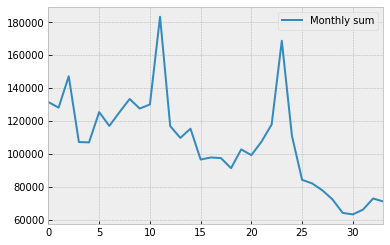

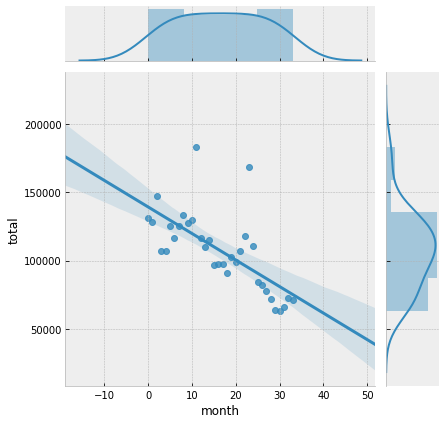

In [33]:
#Plot sales by month block to see the down trend
sales_by_item_id.sum()[1:].plot(legend=True, label="Monthly sum")

ts= pd.DataFrame()
ts['total']=sales_by_item_id.sum()[1:]
ts['month']=ts.index.astype(float)
g = sns.jointplot("month", "total", data=ts, kind="reg")

We have a strong declining monthly trend near -25% per year so we will have to remove that trend from the data for stationnarity for regression and consider the viriable date_block_num into our model

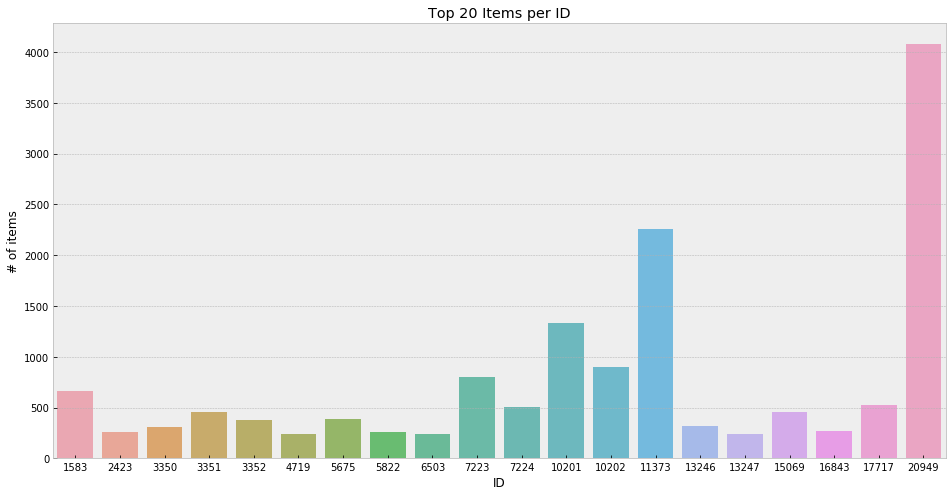

In [34]:
###top 20 selling item in October 2015
October_sales_by_item_id = sales_by_item_id['33']
x=October_sales_by_item_id.to_frame()
x["item_id"]=sales_by_item_id["item_id"]
x=x.rename(columns={ "33":"item_cnt" })
x=x.sort_values(by="item_cnt", ascending=False)
x20=x.head(20)
plt.figure(figsize=(16,8))
ax= sns.barplot(x20.item_id, x20.item_cnt, alpha=0.8)
plt.title("Top 20 Items per ID")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('ID', fontsize=12)
plt.show()

In [36]:
print(dfItems.loc[lambda df1: df1.item_id == 20949,:])

                                               item_name  item_id  \
20949  Фирменный пакет майка 1С Интерес белый (34*42)...    20949   

       item_category_id  
20949                71  


In [37]:
print(dfItems.loc[lambda df1: df1.item_id == 11373,:])

                                  item_name  item_id  item_category_id
11373  Доставка до пункта выдачи (Boxberry)    11373                 9


In [39]:
### pivot_table Group by category sum by date_block_num to get monthly sales by category and chart that.
sales_by_category_id = dfSales.pivot_table(index=['item_category_id'],values=['item_cnt_day'],columns='date_block_num',
                                       aggfunc=np.sum, fill_value=0).reset_index()
sales_by_category_id.columns = sales_by_category_id.columns.droplevel().map(str)
sales_by_category_id = sales_by_category_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_category_id.columns.values[0] = 'item_category_id'


In [40]:
### Top category for October
October_sales_by_category_id = sales_by_category_id['33']
x=October_sales_by_category_id.to_frame()
x["item_category_id"]=sales_by_category_id["item_category_id"]
x=x.rename(columns={ "33":"item_cnt" })
x=x.sort_values(by="item_cnt", ascending=False)
print('top 10 category')
x.head(10)

top 10 category


,item_cnt,item_category_id
40,7680,40
20,6596,20
55,5808,55
30,4150,30
71,4078,71
37,4061,37
47,3421,47
28,2857,28
9,2524,9
19,2443,19


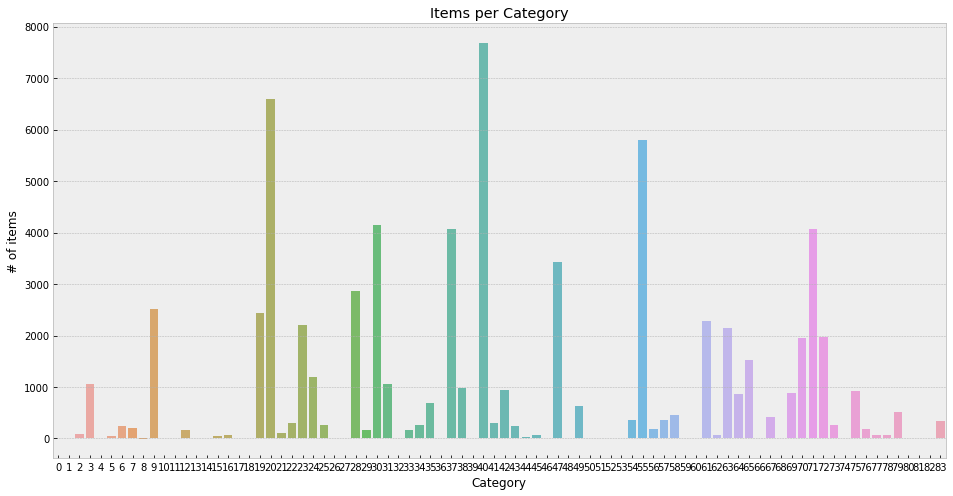

In [43]:
## histogram for category for October_sales_by_category_id
plt.figure(figsize=(16,8))
ax= sns.barplot(x.item_category_id, x.item_cnt, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

look like we don't have category with 0 sales in October to forcast so no totaly new category

In [45]:
###Create a dataframe dfFirst2y to get only the first two full year to do stats per month for seasonlity
### sale Group by month of the year group by category
dfFirst2y=dfSales.loc[lambda df1: df1.date_block_num <= 23,:]
sales_by_month_cid = dfFirst2y.pivot_table(index=['item_category_id'],values=['item_cnt_day'],columns='month',
                                       aggfunc=np.sum, fill_value=0).reset_index()
sales_by_month_cid.columns = sales_by_month_cid.columns.droplevel().map(str)
sales_by_month_cid = sales_by_month_cid.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_month_cid.columns.values[0] = 'item_category_id'


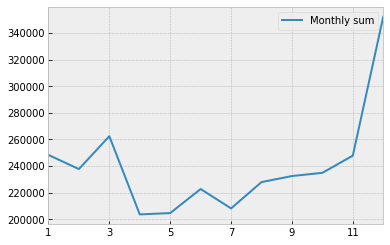

In [46]:
sales_by_month_cid.sum()[1:].plot(legend=True, label="Monthly sum")

Look like in november unit sales are around 5% higher than October for the last 2 year or around 10000 more unit.
We see some sesonality effect with a big peak in December

In [47]:
#Pivot table group by shop id and group by category id
sales_by_item_ids = dfSales.pivot_table(index=['item_category_id'],values=['item_cnt_day'],columns='shop_id',
                                       aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_ids.columns = sales_by_item_ids.columns.droplevel().map(str)
sales_by_item_ids = sales_by_item_ids.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_ids.columns.values[0] = 'item_id'
sales_by_item_ids.head(5)

,item_id,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,105,63,355,200,309,232,422,491,19,...,733,231,250,341,874,0,338,669,324,223
3,3,52,18,527,360,333,340,755,554,0,...,773,247,376,460,1098,0,472,965,574,399
4,4,38,30,42,28,101,38,21,92,2,...,92,56,55,68,103,0,46,149,80,52


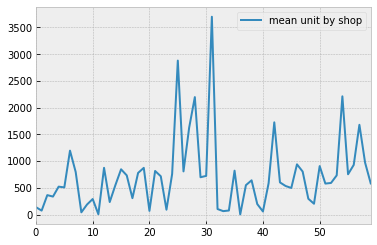

In [48]:
#mean unit by shop plot
sales_by_item_ids.mean()[1:].plot(legend=True, label="mean unit by shop")

Lot of variation by store some sales almot nothing some sales a lot more

# Data manipulation and visualization pt2
# Next part is about more item specific variable that influance unit sales
# Category , age of the item base on the date of the first sale


In [49]:
#We create a data frame DFfirstsale with the aproximate realease date of an item
#this will be use to see the age effect on sale New product sale more than older one
#this will also be use to predict unit sale base on past unit sales for similar product at the same age
sales_by_item_id['total']=Total_sales_by_item['total']

n=sales_by_item_id['item_id'].count()
DFfirstsale=pd.DataFrame([[0, 0]], columns=['item_id','first_month']) 
for i in range(0,n):
    for j in range(0,34):
        j=str(j)
        if sales_by_item_id.loc[i].at[j]>0 and sales_by_item_id.loc[i].at['total']>1:
            #print([sales_by_item.loc[i].at['item_id'] , int(j)])
            df = pd.DataFrame([[sales_by_item_id.loc[i].at['item_id'] , int(j)]],columns=['item_id','first_month'])
            DFfirstsale=DFfirstsale.append(df)
            break

   

In [51]:
#Build a DF with the first 6 months of sale product that have more than 6 months of sales to help to predict new product 
dfnewitem= DFfirstsale.loc[lambda df1: df1.first_month>=30]
dfnewitemtoforc=pd.merge(dfItemListToForc,dfnewitem, on= 'item_id', how='inner')
dfolditem= DFfirstsale.loc[lambda df1: df1.first_month<28 ]
dfolditem= dfolditem.loc[lambda df1:df1.first_month>2]
dfolditem=pd.merge(dfolditem,dfItems, on= 'item_id', how='inner')


In [52]:
#create data frame with the first six month of sales from day out by category 
n=dfolditem['item_id'].count()
DFfirst6msalesbycat=pd.DataFrame([[0,0,0,0,0,0,0]], columns=['item_category_id',1,2,3,4,5,6]) 
for i in range(1,n-2):

    l=[]                                                         
    s=(dfolditem.loc[i].at['first_month'])
    catid=dfolditem.loc[i].at['item_category_id']
    IID=dfolditem.loc[i].at['item_id']
    sales= sales_by_item_id.loc[lambda df1: df1.item_id==IID]
    sales1 = sales.to_numpy()
    sales2=sales1[0,s+1]
    l.append(catid)
    l.append(sales2)
    for j in range(s+2,s+7):
        sales3=sales1[0,j]
        l.append(sales3)

    df = pd.DataFrame([l],columns=['item_category_id',1,2,3,4,5,6])
    DFfirst6msalesbycat=DFfirst6msalesbycat.append(df)
DFfirst6msalesbycat = DFfirst6msalesbycat.reset_index(drop=True)





C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



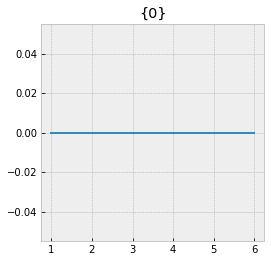

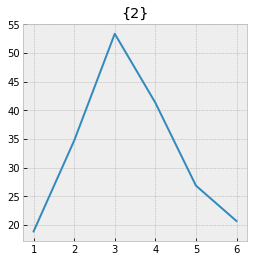

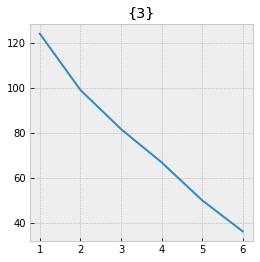

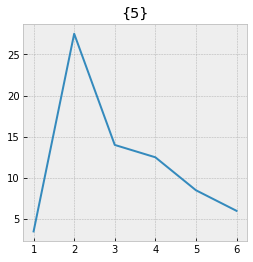

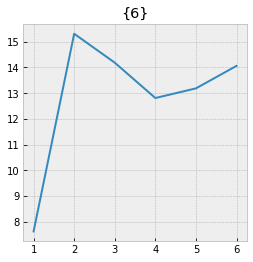

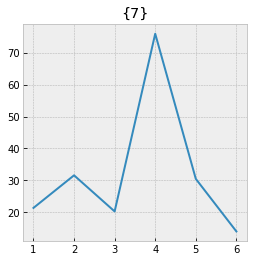

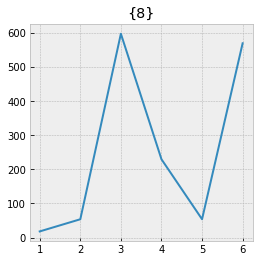

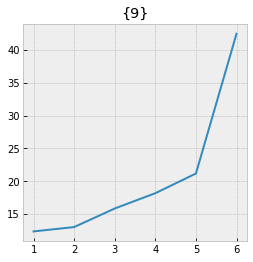

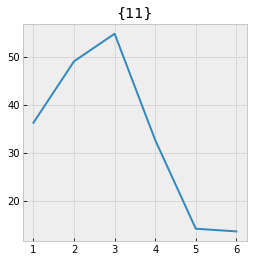

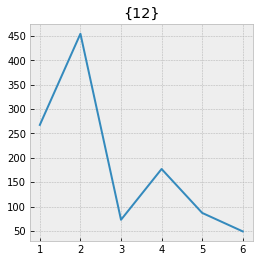

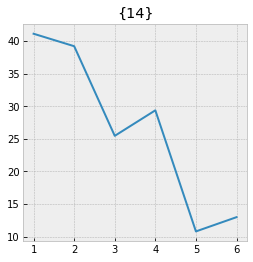

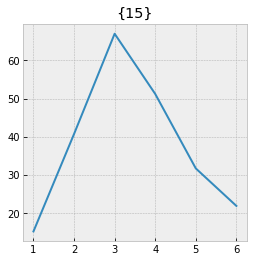

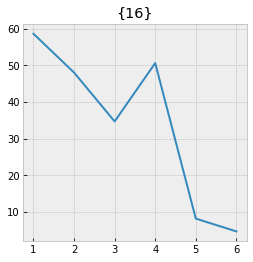

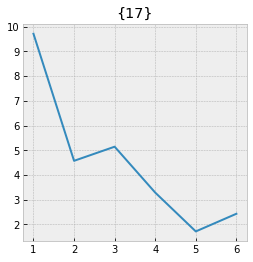

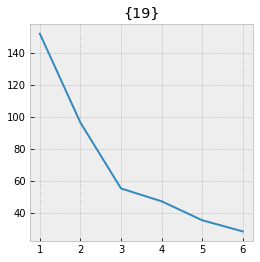

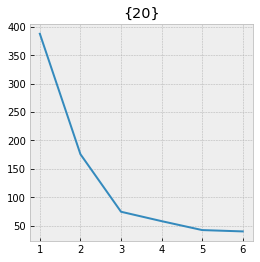

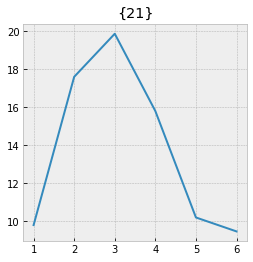

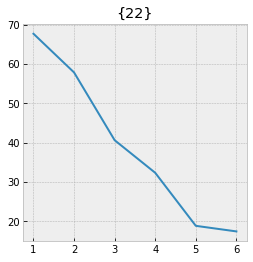

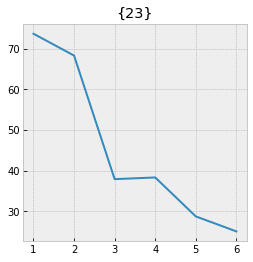

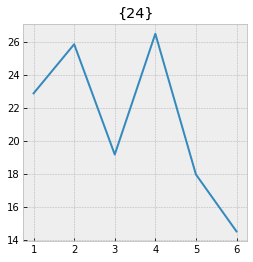

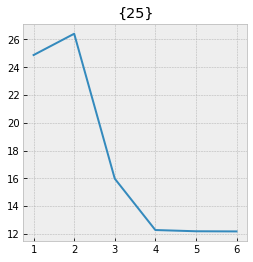

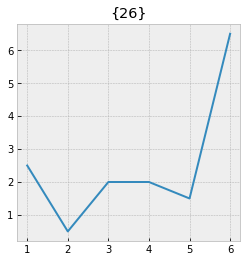

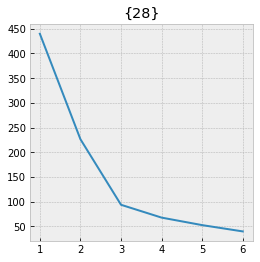

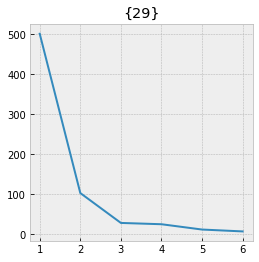

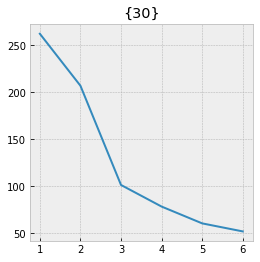

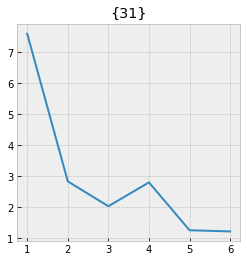

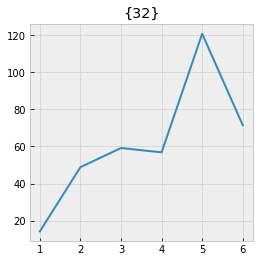

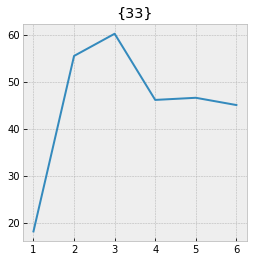

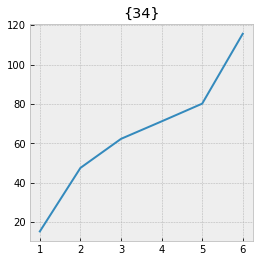

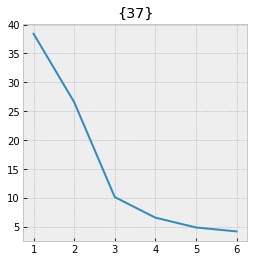

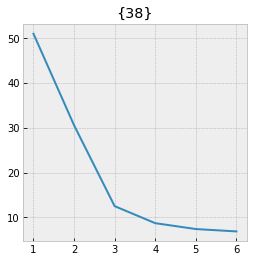

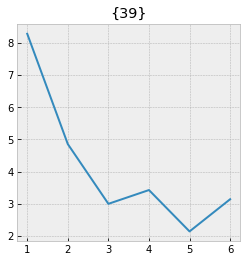

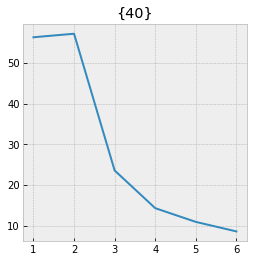

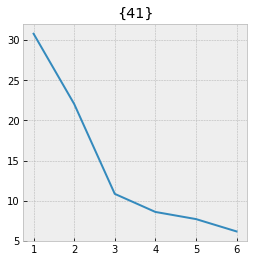

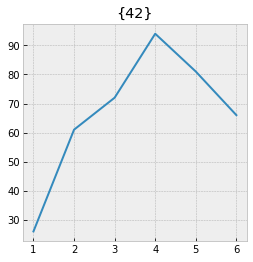

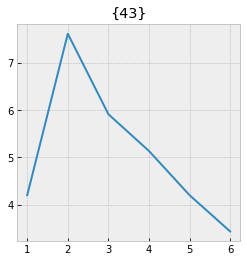

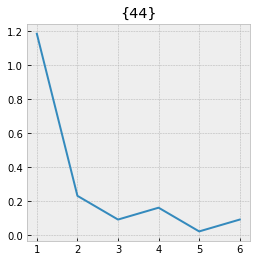

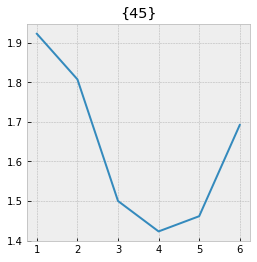

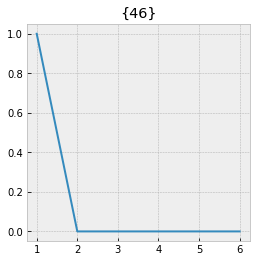

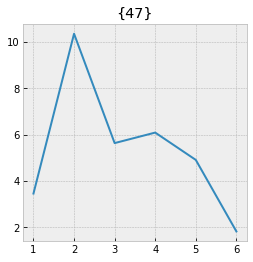

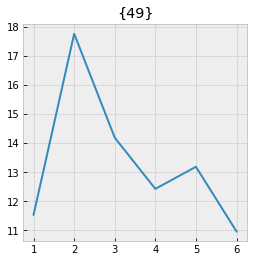

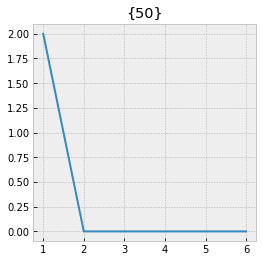

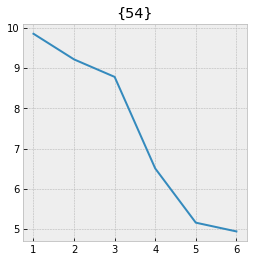

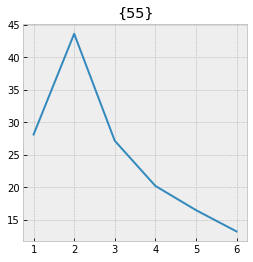

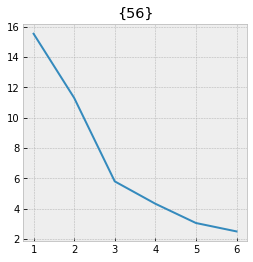

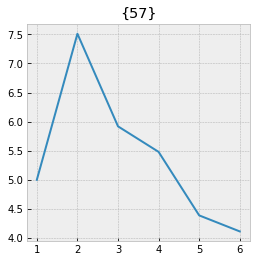

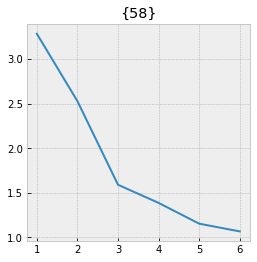

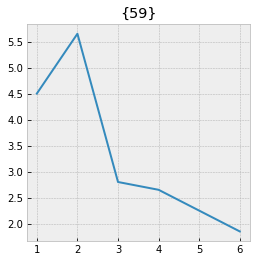

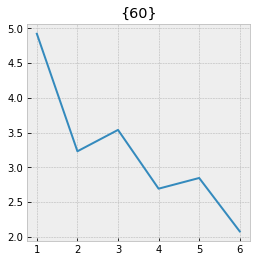

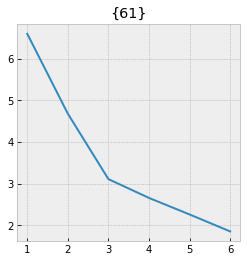

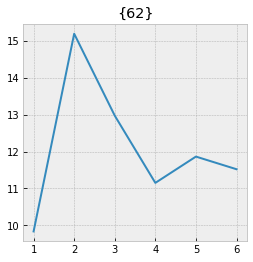

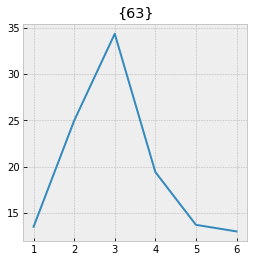

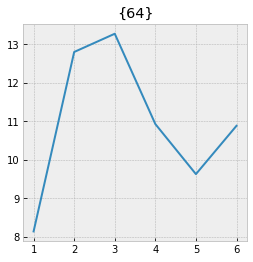

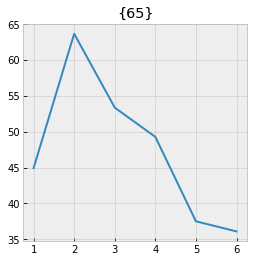

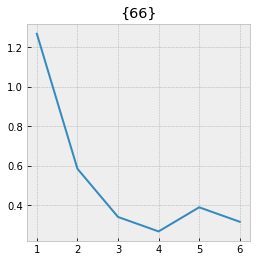

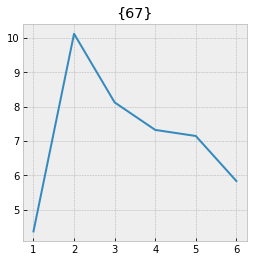

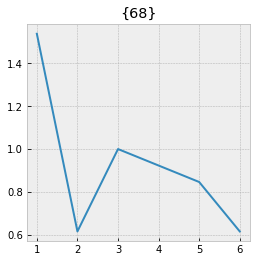

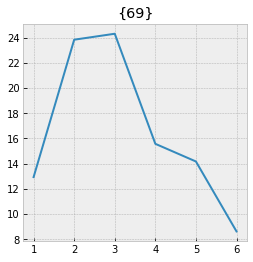

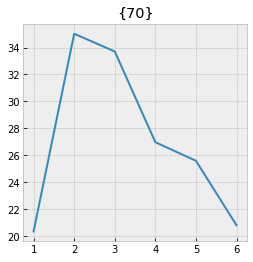

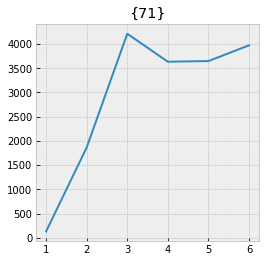

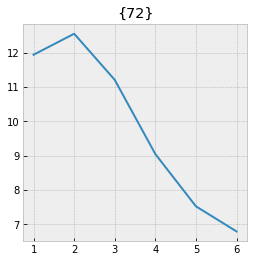

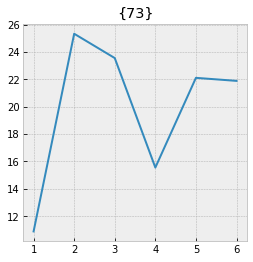

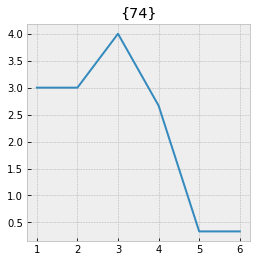

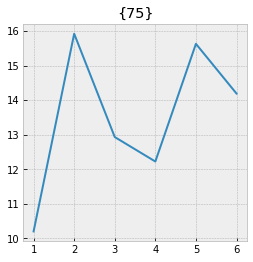

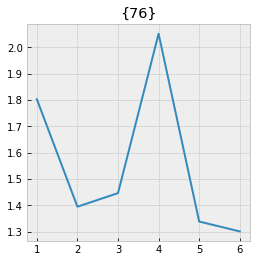

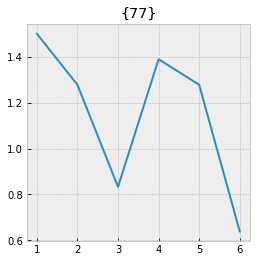

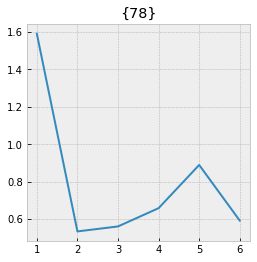

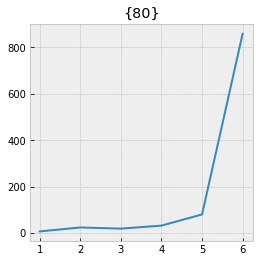

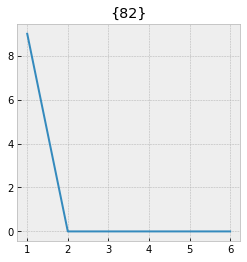

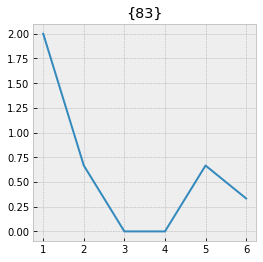

In [53]:
### important to note that we will need to adjust on a monthly basis product the first month 
### base on the day of the first sales of the day and how many days it sales
### If it sales 50 units in the first month but in only 10 days so it's a 150 unit per month rate.
### Chart first 6 month mean unit sale by category
DFfirst6msalesbycatmean=DFfirst6msalesbycat.groupby(['item_category_id']).agg("mean")
dff6m=DFfirst6msalesbycatmean.T# transpose for corr
for col2_idx, column2 in enumerate(dff6m.columns):
    fig, axes = plt.subplots(1, 1, figsize=(4, 4))
    axes.plot(dff6m[column2])
    axes.set_title( {column2})
    #dff6m[column2].plot(legend=True, label="mean monthly unit by store"


We see that for many category sales a deacreasing very fast afther one or two months but for some category they are increasing we most probably 

In [54]:
#we will transforme our sale data by item by date into sale data by item by day since the item relase to forcast sales base
# base past sale of similar product of the same age.

dfSales['date'] =pd.to_datetime(dfSales.date)
dfSales=dfSales.sort_values(by="date", ascending=True)

In [55]:
#remove october from the sale datframe
dfSales=dfSales.loc[lambda df1: df1.date_block_num <= 32,:]

In [56]:
#we get the first day of sales for every item with min agg
firstDay=dfSales.groupby(["item_id"])
firstDay=firstDay.agg({ "date" : 'min',"date_block_num" : 'min', 'item_cnt_day' : 'sum' })
firstDay=firstDay.rename(columns={"date" : "fdate"})
firstDay=firstDay.rename(columns={"item_cnt_day" : "total_cnt"})
firstDay.head(5)

,fdate,date_block_num,total_cnt
item_id,,,
0,2014-09-01,20,1.0
1,2014-04-02,15,6.0
2,2014-08-24,19,2.0
3,2014-07-05,18,2.0
4,2014-09-19,20,1.0


In [59]:
#sort item by day out to see if we got lot of new product
firstDay["days_out"] = firstDay.fdate.apply(lambda df1: (datetime(2015, 9, 30) - df1 )/ np.timedelta64(1, 'D')) 
firstDay['days_out']=pd.to_numeric(firstDay['days_out'], downcast='integer')
firstDayl30=firstDay.loc[lambda df1: df1.days_out <=30 ,:] 
firstDayl30 = firstDayl30.sort_values(by="total_cnt", ascending=False)
firstDayl30.head(20)


,fdate,date_block_num,total_cnt,days_out
item_id,,,,
3351,2015-09-22,32,1569.0,8
4719,2015-09-01,32,829.0,29
4721,2015-09-01,32,663.0,29
3350,2015-09-22,32,652.0,8
3352,2015-09-22,32,622.0,8
4840,2015-09-03,32,593.0,27
4838,2015-09-07,32,409.0,23
15069,2015-09-29,32,301.0,1
4843,2015-09-02,32,265.0,28


We have more than 307 with less than 30 day of data we will need to forcast them with other similar product past data

# We reload all the data and remove month 33 and prepare data to forcast and test on 

In [62]:
#load the csv
dfItemCat = pd.read_csv('item_categories.csv')
dfItems = pd.read_csv('items.csv')
dfItems = pd.merge( dfItems , firstDay, on='item_id')
dfItems=dfItems.drop(columns=['date_block_num'])



In [ ]:
dfSales = pd.read_csv('sales_train.csv')
dfSales.date=dfSales.date.apply(lambda df1:datetime.strptime(df1, '%d.%m.%Y'))
dfSales= pd.merge(dfSales, dfItems , on=['item_id'])

dfSales=dfSales.loc[lambda df1: df1.date_block_num <= 32,:]
dfSales.sort_values(by="date", ascending=False)


In [64]:
dfmonth = pd.DataFrame({'date_block_num': ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18'
                                           ,'19','20','21','22','23','24','25','26','27','28','29','30','31','32','33'],
                        'month': ['1','2','3','4','5','6','7','8','9','10','11','12','1','2','3','4','5','6','7','8','9','10'
                                  ,'11','12','1','2','3','4','5','6','7','8','9','10']})
dfmonth=dfmonth.astype(int)
dfSales = pd.merge(dfSales, dfmonth , on='date_block_num')


In [65]:
#we put the age of the product (days out) for every sales in dfsales
dfSales["days_out"] =(dfSales['date'] - dfSales['fdate'])/ np.timedelta64(1, 'D')
dfSales=dfSales.sort_values(by="date_block_num", ascending=False)
dfSales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,fdate,total_cnt,days_out,month
1041281,2015-09-30,32,25,21937,1549.0,1.0,Шапка Adventure Time Finn плюшевая,61,2015-09-30,1.0,0.0,9
1007563,2015-09-28,32,12,15575,7399.0,1.0,НАУТИЛУС ПОМПИЛИУС Коллекция 2 6LP,58,2014-04-26,23.0,520.0,9
1007561,2015-09-01,32,7,20091,169.0,1.0,УНИВЕРСИТЕТ МОНСТРОВ (регион),40,2014-04-11,365.0,508.0,9
1007560,2015-09-01,32,53,20091,169.0,1.0,УНИВЕРСИТЕТ МОНСТРОВ (регион),40,2014-04-11,365.0,508.0,9
1007559,2015-09-29,32,47,20091,169.0,1.0,УНИВЕРСИТЕТ МОНСТРОВ (регион),40,2014-04-11,365.0,536.0,9


In [66]:
#We create a sample of data from product with more than 10 unit sales and that have been relasesed after 2013, 4,1 
dfNewSalesmodel=dfSales.loc[lambda df1: df1.total_cnt >= 10,:]
dfNewSalesmodel=dfNewSalesmodel.loc[lambda df1: df1.fdate >= datetime(2013, 4,1),:]
dfNewSalesmodel['days_out']=pd.to_numeric(dfNewSalesmodel['days_out'], downcast='integer')


In [68]:
#we create a pivot table from all the sale for all the item we got all the sales in all shop for every signle
#day since the first sale
Newsales_by_ID = dfNewSalesmodel.pivot_table(index=['item_id','item_category_id','fdate'],values=['item_cnt_day'],columns=['days_out'],
                                       aggfunc={'item_cnt_day':np.sum}, fill_value=0).reset_index()
Newsales_by_ID.describe()

item_id item_category_id item_cnt_day               \
days_out                                           0            1   
count      7295.000000      7295.000000  7295.000000  7295.000000   
mean      11357.464016        44.350788    10.798903     7.467032   
std        6278.027064        16.456486    81.463435    52.683013   
min          38.000000         2.000000     1.000000    -1.000000   
25%        5814.500000        31.000000     1.000000     0.000000   
50%       11587.000000        40.000000     1.000000     1.000000   
75%       16588.000000        58.000000     2.000000     3.000000   
max       22167.000000        80.000000  3825.000000  2005.000000   

                                                                           \
days_out            2            3            4            5            6   
count     7295.000000  7295.000000  7295.000000  7295.000000  7295.000000   
mean         5.724195     4.814119     4.190679     3.596299     3.120768   
std         23.898518    18.036089    15.097979    11.343214     9.526352   
min         -1.000000    -1.000000    -3.000000    -1.000000    -1.000000   
25%          0.000000     0.000000     0.000000     0.000000     0.000000   
50%          1.000000     1.000000     1.000000     1.000000     1.000000   
75%          3.000000     3.000000     3.000000     3.000000     3.000000   
max        594.000000   572.000000   541.000000   271.000000   230.000000   

                       ...                                         \
days_out            7  ...          901          902          903   
count     7295.000000  ...  7295.000000  7295.000000  7295.000000   
mean         3.203838  ...     0.000822     0.000411     0.000822   
std         11.640711  ...     0.028669     0.020276     0.040553   
min         -1.000000  ...     0.000000     0.000000     0.000000   
25%          0.000000  ...     0.000000     0.000000     0.000000   
50%          1.000000  ...     0.000000     0.000000     0.000000   
75%          3.000000  ...     0.000000     0.000000     0.000000   
max        626.000000  ...     1.000000     1.000000     3.000000   

                                                                           \
days_out          904          905          906          907          908   
count     7295.000000  7295.000000  7295.000000  7295.000000  7295.000000   
mean         0.001097     0.000411     0.000685     0.000411     0.000548   
std          0.082787     0.020276     0.030971     0.026179     0.028676   
min          0.000000     0.000000     0.000000     0.000000     0.000000   
25%          0.000000     0.000000     0.000000     0.000000     0.000000   
50%          0.000000     0.000000     0.000000     0.000000     0.000000   
75%          0.000000     0.000000     0.000000     0.000000     0.000000   
max          7.000000     1.000000     2.000000     2.000000     2.000000   

                                    
days_out          909          910  
count     7295.000000  7295.000000  
mean         0.000411     0.000411  
std          0.026179     0.026179  
min          0.000000     0.000000  
25%          0.000000     0.000000  
50%          0.000000     0.000000  
75%          0.000000     0.000000  
max          2.000000     2.000000  

[8 rows x 913 columns]

In [69]:
#pivot table with date block month by days out for trend
Newsales_by_ID_db = dfNewSalesmodel.pivot_table(index=['item_id','item_category_id','fdate'],values=['date_block_num'],columns=['days_out'],
                                       aggfunc=np.mean, fill_value=0).reset_index()

Newsales_by_ID_db.head(5)

item_id item_category_id      fdate date_block_num                 \
days_out                                                  0  1   2   3   4   
0             38               41 2014-07-11             18  0   0   0   0   
1             62               37 2014-03-19             14  0   0   0   0   
2             64               40 2014-08-30             19  0  20  20  20   
3             65               37 2013-04-11              3  0   3   0   0   
4             66               37 2013-04-11              3  3   3   0   0   

                  ...                                          
days_out   5   6  ... 901 902 903 904 905 906 907 908 909 910  
0          0  18  ...   0   0   0   0   0   0   0   0   0   0  
1          0   0  ...   0   0   0   0   0   0   0   0   0   0  
2         20   0  ...   0   0   0   0   0   0   0   0   0   0  
3          3   0  ...   0   0   0   0   0   0   0   0   0   0  
4          3   3  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 914 columns]

In [70]:
#pivot table with  month of the year by days out for seasonality 
Newsales_by_ID_ymonth = dfNewSalesmodel.pivot_table(index=['item_id','item_category_id','fdate'],values=['month'],columns=['days_out'],
                                       aggfunc=np.mean, fill_value=0).reset_index()

Newsales_by_ID_ymonth.head()

item_id item_category_id      fdate month                    ...      \
days_out                                         0  1  2  3  4  5  6  ... 901   
0             38               41 2014-07-11     7  0  0  0  0  0  7  ...   0   
1             62               37 2014-03-19     3  0  0  0  0  0  0  ...   0   
2             64               40 2014-08-30     8  0  9  9  9  9  0  ...   0   
3             65               37 2013-04-11     4  0  4  0  0  4  0  ...   0   
4             66               37 2013-04-11     4  4  4  0  0  4  4  ...   0   

                                              
days_out 902 903 904 905 906 907 908 909 910  
0          0   0   0   0   0   0   0   0   0  
1          0   0   0   0   0   0   0   0   0  
2          0   0   0   0   0   0   0   0   0  
3          0   0   0   0   0   0   0   0   0  
4          0   0   0   0   0   0   0   0   0  

[5 rows x 914 columns]

In [75]:
#sale by item by shop for every day out  for by shop by item forecast

Newsales_by_ID_byshop = dfNewSalesmodel.pivot_table(index=['item_id','item_category_id','fdate','shop_id'],values=['item_cnt_day'],columns=['days_out'],
                                       aggfunc={'item_cnt_day':np.sum}, fill_value=0).reset_index()
Newsales_by_ID_byshop.head()

item_id item_category_id      fdate shop_id item_cnt_day              \
days_out                                                        0  1  2  3  4   
0             38               41 2014-07-11       4            0  0  0  0  0   
1             38               41 2014-07-11       6            0  0  0  0  0   
2             38               41 2014-07-11      10            0  0  0  0  0   
3             38               41 2014-07-11      12            0  0  0  0  0   
4             38               41 2014-07-11      13            0  0  0  0  0   

             ...                                          
days_out  5  ... 901 902 903 904 905 906 907 908 909 910  
0         0  ...   0   0   0   0   0   0   0   0   0   0  
1         0  ...   0   0   0   0   0   0   0   0   0   0  
2         0  ...   0   0   0   0   0   0   0   0   0   0  
3         0  ...   0   0   0   0   0   0   0   0   0   0  
4         0  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 915 columns]

In [76]:
### Group by category average by days_out to get daily sales by category model.
Newsales_by_Cat = dfNewSalesmodel.pivot_table(index=['item_category_id'],values=['item_cnt_day'],columns=['days_out'],
                                       aggfunc=np.sum, fill_value=0).reset_index()

Newsales_by_Cat.head(5)

item_category_id item_cnt_day                                     \
days_out                             0    1    2    3    4    5    6    7   
0                       2           27   14   14   29   28   26   24   32   
1                       3          539  195  114  130  164  150  156  143   
2                       5            3    0    2    0    1    0    0    0   
3                       6           16    5   11    6   11   12   12    3   
4                       7          160   30   36   35   31   23   28   39   

               ...                                          
days_out    8  ... 901 902 903 904 905 906 907 908 909 910  
0          27  ...   0   0   0   0   0   0   0   0   0   0  
1         186  ...   0   0   0   0   0   0   0   0   0   0  
2           0  ...   0   0   0   0   0   0   0   0   0   0  
3           8  ...   0   0   0   0   0   0   0   0   0   0  
4          40  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 912 columns]

In [77]:
#item cnt by days out for every category 
Newsales_by_Catstd = dfNewSalesmodel.pivot_table(index=['item_category_id'],values=['item_cnt_day'],columns=['days_out'],
                                       aggfunc=np.std, fill_value=0).reset_index()

Newsales_by_Catstd.head(5)

item_category_id item_cnt_day                                \
days_out                             0         1         2         3   
0                       2     0.196116  0.277350  0.000000  0.188982   
1                       3     4.298195  1.500519  0.707554  0.853592   
2                       5     0.000000  0.000000  0.000000  0.000000   
3                       6     0.000000  0.500000  0.316228  0.000000   
4                       7     2.644272  0.262265  0.373878  0.171499   

                                                           ...               \
days_out         4         5         6         7        8  ...  898 899 901   
0         0.271746  0.200000  0.294245  0.365148  0.00000  ...  0.0   0   0   
1         0.865463  0.758281  0.628205  0.761120  1.08349  ...  0.0   0   0   
2         0.000000  0.000000  0.000000  0.000000  0.00000  ...  0.0   0   0   
3         0.000000  0.000000  0.301511  0.000000  0.00000  ...  0.0   0   0   
4         0.456045  0.418854  0.587137  0.468209  0.42997  ...  0.0   0   0   

                                       
days_out 903  904 906 907 908 909 910  
0          0  0.0   0   0   0   0   0  
1          0  0.0   0   0   0   0   0  
2          0  0.0   0   0   0   0   0  
3          0  0.0   0   0   0   0   0  
4          0  0.0   0   0   0   0   0  

[5 rows x 908 columns]

## More visualization on the age effect on sale for different category

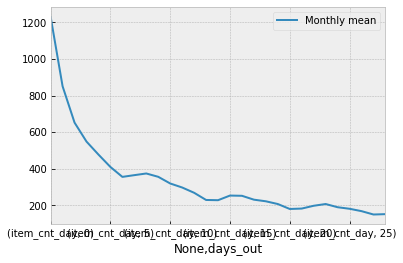

In [78]:
#chart by age for all the category by store average
Newsales_by_Cat.mean()[1:30].plot(legend=True, label="Monthly mean")


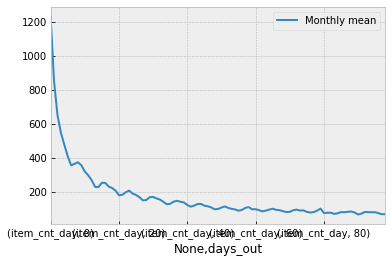

In [79]:
#chart  by age for all the category by store average
Newsales_by_Cat.mean()[1:100].plot(legend=True, label="Monthly mean")


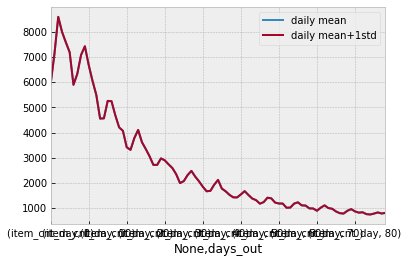

In [80]:
#chart by age for the category 40 with +1 std
Newsales_by_Cat40=Newsales_by_Cat.loc[lambda df1: df1.item_category_id == 40,:]
Newsales_by_Cat40.sum()[1:90].plot(legend=True, label="daily mean")
Newsales_by_Catstd40=Newsales_by_Catstd.loc[lambda df1: df1.item_category_id == 40,:]
(Newsales_by_Cat40.sum()[1:90]+Newsales_by_Catstd40.sum()[1:90]).plot(legend=True, label="daily mean+1std")

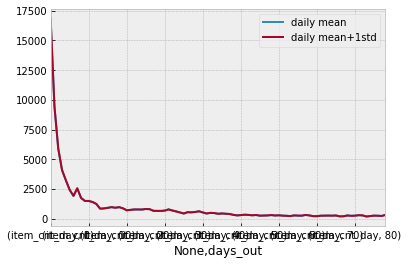

In [81]:
#chart by age for the category 20 with +1 std
Newsales_by_Cat20=Newsales_by_Cat.loc[lambda df1: df1.item_category_id == 20,:]
Newsales_by_Cat20.sum()[1:90].plot(legend=True, label="daily mean")
Newsales_by_Catstd20=Newsales_by_Catstd.loc[lambda df1: df1.item_category_id == 20,:]
(Newsales_by_Cat20.sum()[1:90]+Newsales_by_Catstd20.sum()[1:90]).plot(legend=True, label="daily mean+1std")
#Newsales_by_Cat20.sum()[1:300].plot(legend=True, label="daily mean")

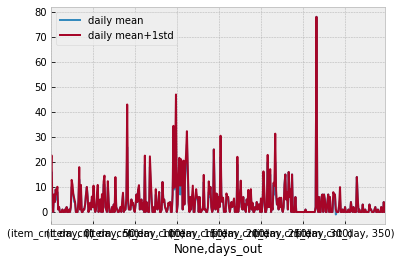

In [82]:
#chart by age for the category 55 with +1 std
Newsales_by_Cat55=Newsales_by_Cat.loc[lambda df1: df1.item_category_id == 9,:]
#Newsales_by_Cat55.sum()[1:30].plot(legend=True, label="daily mean")
Newsales_by_Cat55.sum()[1:400].plot(legend=True, label="daily mean")
Newsales_by_Catstd55=Newsales_by_Catstd.loc[lambda df1: df1.item_category_id == 9,:]
(Newsales_by_Cat55.sum()[1:400]+Newsales_by_Catstd55.sum()[1:400]).plot(legend=True, label="daily mean+1std")

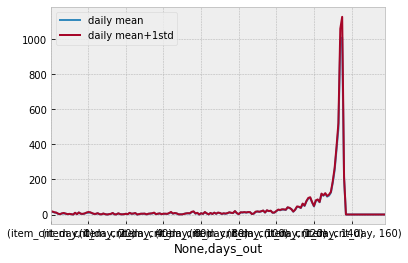

In [83]:
#chart by age for the category 30 with +1 std
Newsales_by_Cat30=Newsales_by_Cat.loc[lambda df1: df1.item_category_id == 80,:]
Newsales_by_Cat30.sum()[1:180].plot(legend=True, label="daily mean")
Newsales_by_Catstd30=Newsales_by_Catstd.loc[lambda df1: df1.item_category_id ==80,:]
(Newsales_by_Cat30.sum()[1:180]+Newsales_by_Catstd30.sum()[1:180]).plot(legend=True, label="daily mean+1std")

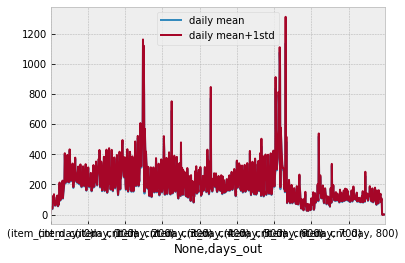

In [84]:
#chart by age for the category 30 with +1 std
Newsales_by_Cat30=Newsales_by_Cat.loc[lambda df1: df1.item_category_id == 71,:]
Newsales_by_Cat30.sum()[1:900].plot(legend=True, label="daily mean")
Newsales_by_Catstd30=Newsales_by_Catstd.loc[lambda df1: df1.item_category_id ==71,:]
(Newsales_by_Cat30.sum()[1:900]+Newsales_by_Catstd30.sum()[1:900]).plot(legend=True, label="daily mean+1std")

## Category 9 and 71 are very randum look like with noise with some volatility jump a bit like stock market return

category  8 and 80 is very different from other category, It's ticket for event so it's doing an exponential expantion going into the event and drop to 0 after the event so we need a different model to predict this category.
date of the event is in the item name so we need to translate russian month into datetime and build an exponential model base on time before the event   

# We will try to predict by item by store and by item for overall the shops and distributes to shops by market shares to see witch method is the best our itutions is data by shop have to many 0 and many item will not have enought data to prdict at shop level. We will use ARIMA and linear regression base on item sale from the same category at the same age to predict sales by item. Item with less than 3 month of data will be forcast with linear regression only Item with 3 month of data to 800 day will be forcast with lin reg and arima and item with more than 800 days of data will be forcast with Arima only

In [85]:
### fonction to forcat item sale by the age of the product with similar product from same category
import time

def next30daySalesByMeanSTD(id,nday,now,db,month,dfItems,Newsales_by_Cat,Newsales_by_Catstd,Newsales_by_ID):
    print(id)
    dfforc=pd.DataFrame()#df to put forcast to be return in the function
    dfforc['item_id']=[id]
    ###################################################################################
    # Lot of data manipilation to create df to train an df to forcast                 #
    now=datetime(2015, 9, 30)
    item=dfItems.loc[lambda df1: df1.item_id ==id,:]                                  #
    idate=item['fdate']
    idate=idate.to_numpy(dtype="datetime64[D]")                                       # 
    idatets=(idate - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  #
    idate=datetime.utcfromtimestamp(idatets)
    dayout= np.asscalar(item['days_out'].to_numpy())                                  #
    if dayout>(now-datetime(2013, 4,1)).days-35:
        dayout=(now-datetime(2013, 4,1)).days -35                                     #
    cat=np.asscalar(item['item_category_id'].to_numpy())
    isale= Newsales_by_ID.loc[lambda df1: df1.item_id ==id,:]                         #
    isale=isale['item_cnt_day']
    sample=Newsales_by_ID.loc[lambda df1: df1.item_category_id ==cat,:]               #
    sample=sample.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
    sample=sample.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]           #
    sampledb=Newsales_by_ID_db.loc[lambda df1: df1.item_category_id ==cat,:]
    sampledb=sampledb.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]        #
    sampledb=sampledb.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]       #
    sampleym=Newsales_by_ID_ymonth.loc[lambda df1: df1.item_category_id ==cat,:]      #
    sampleym=sampleym.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]        #
    sampleym=sampleym.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]       #
    sample2=sample['item_cnt_day']
    sampledb=sampledb['date_block_num']                                               #
    sampleym=sampleym['month']
    ###################################################################################

    X=pd.DataFrame() #df to train
    XF=pd.DataFrame() #df to forc

    #List of columns related to the time periode we want to forcast 
    if dayout<nday:
        col_list=list(range(0,dayout+1))
    else:
        col_list=list(range(dayout-nday,dayout+1))

    if dayout<7:
        lweek_list=list(range(0,dayout+1))
    else:
        lweek_list=list(range(dayout-7,dayout+1))

    fcol_list=list(range(dayout+2,dayout+2+nday))
    #####################################################################################

    X['nt']=sample2[col_list].to_numpy().sum(axis=1)

    if dayout>31: #use autoregressive model
    ############# ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA #################################
        stst = pd.DataFrame()
        stsy = pd.DataFrame()
        sts=dfSales.loc[lambda df1: df1.item_id	 == id,:]
        sts=sts.groupby(['date_block_num']).agg({"item_cnt_day":"sum"})
        sts=sts.rename(columns={'date_block_num' : 'ds', 'item_cnt_day' : 'y'})
        stst['ds']=sts.index
        stst['ds']=stst['ds'].apply(lambda df1: datetime(2013, 1, 1)+relativedelta(months=+df1))
        stsy=(sts['y'].to_numpy())
        stsy=np.log(stsy)#log for stationarity
        if len(stsy)>4 and stsy.std()>0 and stsy.sum()/dayout>1/30:
            if dayout>400 and len(stsy)>12: #model with sesonality               
                pipeline = Pipeline([
                 ('fourier', FourierFeaturizer(k=1, m=12)),
                 ("model", pm.AutoARIMA(seasonal=True,d=1 , suppress_warnings=True, error_action="ignore"))])#auto fit sarima
                pipeline2 = Pipeline([
                ("model", pm.ARIMA(order=(1, 0,0), seasonal_order=(1,0, 0, 12), suppress_warnings=True))]) #basic arima p=1 s=12 
            else: #with no sesonality less than 1 year of data                 
                pipeline = Pipeline([
                 ("model", pm.AutoARIMA(seasonal=False,d=1 , suppress_warnings=True , error_action="ignore"))])#auto fit arima
                pipeline2 = Pipeline([
                ("model", pm.ARIMA(order=(1, 0,0), suppress_warnings=True))])#basic arima p=1   
            
            pipeline.fit(stsy)#fit auto
            pred=pipeline.predict(1)#predict 1 with auto
            pred=np.exp(pred)#inverse log

            pipeline2.fit(stsy)#fit basic
            pred2=pipeline2.predict(1)#predict 1 with basic
            pred2=np.exp(pred2)#inverse log
            
        else:
            pred=[0]
            pred2=[0]

        dfforc['autoARIMA']=max(pred,[0]) 
        dfforc['ARIMA_10012']=max(pred2,[0])
        dfforc['lastmonth']=np.exp(stsy[-1])


    if dayout<800 and len(X.index)>=3:
    ############# LinearRegression LinearRegression LinearRegression LinearRegression   ###################################################

        # X to train XF to forcast                    
        X['LastW']=sample2[lweek_list].to_numpy().sum(axis=1)#sum last 7 day less volatyle than last day
        XF['LastW']=isale[lweek_list].to_numpy().sum(axis=1)
        XF['nt']=isale[col_list].to_numpy().sum(axis=1)
        X['y']=sample2[fcol_list].to_numpy().sum(axis=1)#for all item sum the sales on the same age we try to forcast
        X['db']=sampledb[fcol_list].to_numpy().max(axis=1)#for all item the date_block_num at that same age to adjust to time trend
        XF['db']=db
        m=sampleym[fcol_list].to_numpy().max(axis=1)#m is the month of the coreponding to the age 
        X['mstd']= (((X['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()# mstd is mean std ajusted prediction 
        XF['mstd']= (((XF['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()
        #base on category history and sale history we have for the item we try to 
        X['db']=X['db']*X['mstd'] # db * mstd to adjust forcast to trend
        XF['db']=XF['db']*XF['mstd']
        X['Last']=sample2[dayout].to_numpy()
        XF['Last']=isale[dayout].to_numpy()
        XF=XF.fillna(0)
        if XF['nt'].empty==True or X['nt'].std() ==0:
             dfforc['reg_lin_mul']=XF['LastW']*4.2
        else:
            #we create 12 variable for every month of the year and put mstd in its coresponfing month to catch the seasonality                                           
            for i in range(1,13):
                X['s'+str(i)]=0                                            
            j=0  
            for i in m: 
                if i==0:
                    i=1
                X.loc[j,'s'+str(i)]=X.loc[j,'mstd']
                j=j+1
            Y=X['y'] 
            X=X.fillna(0)
            Y=Y.fillna(0)
            X1=X.drop(columns=['y','mstd','nt'])#drop mstd 'nt'
            X2=X.drop(columns=['y','mstd','db','nt'])#drop mstd 'nt' dt
            X3=X.drop(columns=['y','nt','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12'])#drop mstd 'nt' dt season
            X4=X.drop(columns=['y','nt','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','db','Last'])
            #print(X1)          

            X1=X1.to_numpy()
            X2=X2.to_numpy()
            X3=X3.to_numpy()
            X4=X4.to_numpy()
            Y=Y.to_numpy()
            ###############################################################
            # FIT X Y                
            reg1 = LinearRegression().fit(X1, Y)#build lin reg model 1
            reg2 = LinearRegression().fit(X2, Y)#build lin reg model 2
            reg3 = LinearRegression().fit(X3, Y)#build lin reg model 3
            reg4 = LinearRegression().fit(X4, Y)#build lin reg model 4
            ##                                                            ##
            ################################################################
            
            ##################################################################
            #prepare XF dataframe to forcast 
            for i in range(1,13):                             
                XF['s'+str(i)]=0                                
            XF.loc[0,'s'+str(month)]=XF.loc[0,'mstd']          
            XF=XF.fillna(0) 
            
            XF1=XF.drop(columns=['mstd','nt'])
            XF2=XF.drop(columns=['mstd','db','nt'])
            XF3=XF.drop(columns=['nt','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12'])#drop mstd 'nt' 
            XF4=XF.drop(columns=['nt','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','db','Last'])
            #print(XF1)
            XF1=XF1.to_numpy()                                   
            XF2=XF2.to_numpy()                                   
            XF3=XF3.to_numpy()
            XF4=XF4.to_numpy()
            ##################################################### 
            
            #################################################################
            # FROC
            forc1 =max([0],reg1.predict(XF1))#forcast 1 
            forc2 =max([0],reg2.predict(XF2))#forcast 2
            forc3 =max([0],reg3.predict(XF3))#forcast 3
            forc4 =max([0],reg4.predict(XF4))#forcast 4
            if forc1>np.sum([forc2,forc3,forc4])*2: forc1=[np.sum([forc2,forc3,forc4])/3]
            if forc2>np.sum([forc1,forc3,forc4])*2: forc2=[np.sum([forc1,forc3,forc4])/3]
            if forc3>np.sum([forc2,forc1,forc4])*2: forc3=[np.sum([forc2,forc1,forc4])/3]
            if forc4>np.sum([forc2,forc3,forc1])*2: forc4=[np.sum([forc2,forc3,forc1])/3]
            dfforc['reg_lin_mul1']=forc1# add forcast to forcast 1 dataframe
            dfforc['reg_lin_mul2']=forc2# add forcast to forcast 2 dataframe
            dfforc['reg_lin_mul3']=forc3# add forcast to forcast 3 dataframe
            dfforc['reg_lin_mul4']=forc4# add forcast to forcast 4 dataframe
    #print(dfforc)
    return dfforc

In [86]:
#This is to forcast only one item like the fonction and to take a look at particular issue with shop
def next30dayShopSalesByMeanSTD(id,shop,nday,now,db,month,dfItems,Newsales_by_Cat,Newsales_by_Catstd,Newsales_by_ID):
    #print(id)
    #print(shop)
    
    dfforc=pd.DataFrame()
    dfforc['item_id']=[id]
    dfforc['shop_id']=[shop]
    now=datetime(2015, 9, 30)
    item=dfItems.loc[lambda df1: df1.item_id ==id,:]
    idate=item['fdate']
    idate=idate.to_numpy(dtype="datetime64[D]")
    idatets=(idate - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    idate=datetime.utcfromtimestamp(idatets)
    dayout= np.asscalar(item['days_out'].to_numpy())
    if dayout>(now-datetime(2013, 4,1)).days-35:
        dayout=(now-datetime(2013, 4,1)).days -35
    cat=np.asscalar(item['item_category_id'].to_numpy())
    isale= Newsales_by_ID_byshop.loc[lambda df1: df1.item_id ==id ,:]
    isale= isale.loc[lambda df1: df1.shop_id ==shop ,:]
    isale=isale.set_index('item_id')
    isale=isale['item_cnt_day']
    sample=Newsales_by_ID_byshop.loc[lambda df1: df1.item_category_id ==cat ,:]
    sample=sample.loc[lambda df1:df1.shop_id ==shop,:]
    sample=sample.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
    sample=sample.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]
    sample=sample.set_index('item_id')
    sample2=sample['item_cnt_day']

    X=pd.DataFrame()
    XF=pd.DataFrame()
    if dayout<nday:
        col_list=list(range(0,dayout+1))
    else:
        col_list=list(range(dayout-nday,dayout+1))
    fcol_list=list(range(dayout+2,dayout+2+nday))

    if dayout<7:
        lweek_list=list(range(0,dayout+1))
    else:
        lweek_list=list(range(dayout-7,dayout+1))

    X['nt']=sample2[col_list].to_numpy().sum(axis=1)

    if dayout>31: #use autoregressive model
    ############# ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA #################################
        stst = pd.DataFrame()
        stsy = pd.DataFrame()
        sts=dfSales.loc[lambda df1: df1.item_id	 == id ,:]
        sts=sts.loc[lambda df1:df1.shop_id ==shop,:]
        sts=sts.groupby(['date_block_num']).agg({"item_cnt_day":"sum"})
        sts=sts.rename(columns={'date_block_num' : 'ds', 'item_cnt_day' : 'y'})
        stst['ds']=sts.index
        stst['ds']=stst['ds'].apply(lambda df1: datetime(2013, 1, 1)+relativedelta(months=+df1))
        stsy=(sts['y'].to_numpy())
        stsy=np.log(stsy)#log for stationarity
        if len(stsy)>4 and stsy.std()>0 and stsy.sum()/dayout>1/30:
            if dayout>400 and len(stsy)>12: #model with sesonality               
                pipeline = Pipeline([
                 ('fourier', FourierFeaturizer(k=1, m=12)),
                 ("model", pm.AutoARIMA(seasonal=True,d=1 , suppress_warnings=True))])#auto fit sarima
                pipeline2 = Pipeline([
                ("model", pm.ARIMA(order=(1, 0,0), seasonal_order=(1,0, 0, 12), suppress_warnings=True))]) #basic arima p=1 s=12 
            else: #with no sesonality less than 1 year of data                 
                pipeline = Pipeline([
                 ("model", pm.AutoARIMA(seasonal=False,d=1 , suppress_warnings=True))])#auto fit arima
                pipeline2 = Pipeline([
                ("model", pm.ARIMA(order=(1, 0,0), suppress_warnings=True))])#basic arima p=1   

            pipeline.fit(stsy)#fit auto
            pred=pipeline.predict(1)#predict 1 with auto
            pred=np.exp(pred)#inverse log

            pipeline2.fit(stsy)#fit basic
            pred2=pipeline2.predict(1)#predict 1 with basic
            pred2=np.exp(pred2)#inverse log

        else:
            pred=[0]
            pred2=[0]

        dfforc['autoARIMA']=max(pred,[0]) 
        dfforc['ARIMA_10012']=max(pred2,[0])
        if len(stsy)>0:
            dfforc['lastmonth']=np.exp(stsy[-1])
        else:
            dfforc['lastmonth']=0

    if dayout<800 and len(X.index)>=3:
         # X to train XF to forcast  
            #print(sample2)
            X['LastW']=sample2[lweek_list].to_numpy().sum(axis=1)#sum last 7 day less volatyle than last day
            XF['LastW']=isale[lweek_list].to_numpy().sum(axis=1)
            XF['nt']=isale[col_list].to_numpy().sum(axis=1)
            X['y']=sample2[fcol_list].to_numpy().sum(axis=1)#for all item sum the sales on the same age we try to forcast
     

            X['mstd']= (((X['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()# mstd is mean std ajusted prediction 
            XF['mstd']= (((XF['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()

            X['Last']=sample2[dayout].to_numpy()
            XF['Last']=isale[dayout].to_numpy()
            XF=XF.fillna(0)
            if XF['nt'].empty==True or X['nt'].std() ==0:
                 dfforc['reg_lin_mul']=XF['LastW']*4.2
            else:
                Y=X['y'] 
                X=X.fillna(0)
                Y=Y.fillna(0)            
                X1=X.drop(columns=['y','nt'])#drop mstd 'nt'
                X2=X.drop(columns=['y','mstd','nt'])#drop mstd 'nt' dt
                X3=X.drop(columns=['y','Last'])#drop mstd 'nt' 
                X4=X.drop(columns=['y','nt','Last'])#drop mstd 'nt' dt
                X1=X1.to_numpy()
                X2=X2.to_numpy()
                X3=X3.to_numpy()
                X4=X4.to_numpy()
                Ydf=Y          
                Y=Y.to_numpy()
                ###############################################################
                # FIT X Y 
                reg1 = LinearRegression().fit(X1, Y)#build lin reg model 1
                reg2 = LinearRegression().fit(X2, Y)#build lin reg model 2
                reg3 = LinearRegression().fit(X3, Y)#build lin reg model 3
                reg4 = LinearRegression().fit(X4, Y)#build lin reg model 4
                ##                                                            ##
                ################################################################

                ##################################################################
                #prepare XF dataframe to forcast      
                XF=XF.fillna(0) 
                XF1=XF.drop(columns=['nt'])#drop mstd 'nt'
                XF2=XF.drop(columns=['mstd','nt'])#drop mstd 'nt' dt
                XF3=XF.drop(columns=['Last'])#drop mstd 'nt' 
                XF4=XF.drop(columns=['nt','Last'])#drop mstd 'nt' dt
                XF1=XF1.to_numpy()                                   
                XF2=XF2.to_numpy()                                   
                XF3=XF3.to_numpy()
                XF4=XF4.to_numpy()
                ##################################################### 

                #################################################################
                # FROC

                forc1 =max([0],reg1.predict(XF1))#forcast 1 
                forc2 =max([0],reg2.predict(XF2))#forcast 2
                forc3 =max([0],reg3.predict(XF3))#forcast 3
                forc4 =max([0],reg4.predict(XF4))#forcast 4 
                if forc1>np.sum([forc2,forc3,forc4])*2: forc1=[np.sum([forc2,forc3,forc4])/3]
                if forc2>np.sum([forc1,forc3,forc4])*2: forc2=[np.sum([forc1,forc3,forc4])/3]
                if forc3>np.sum([forc2,forc1,forc4])*2: forc3=[np.sum([forc2,forc1,forc4])/3]
                if forc4>np.sum([forc2,forc3,forc1])*2: forc4=[np.sum([forc2,forc3,forc1])/3]
                dfforc['reg_lin_mul1']=forc1# add forcast to forcast 1 dataframe
                dfforc['reg_lin_mul2']=forc2# add forcast to forcast 2 dataframe
                dfforc['reg_lin_mul3']=forc3# add forcast to forcast 3 dataframe
                dfforc['reg_lin_mul4']=forc4# add forcast to forcast 4 dataframe
    return dfforc

In [87]:
#create a data frame of all the sales with out October
#create a data frame of all the item we need to forcast for October

dfSalesT = pd.read_csv('sales_train.csv')
dftest=pd.read_csv('test.csv')
dfushop=dftest['shop_id'].unique()
dfuitem=dftest['item_id'].unique()

dfSalesT = dfSalesT.loc[lambda df1: df1.date_block_num == 33,:]
itemtoforctest = dfSales.loc[lambda df1: df1.date_block_num == 32,:]
itemtoforctest = itemtoforctest.groupby(['item_id']).agg("sum")
listItemTest = itemtoforctest.index
dfSalesT = dfSalesT.groupby(['item_id']).agg("sum")


for i in listItemTest:
    if i in dfSalesT.index:
        itemtoforctest.loc[i,'item_cnt']=dfSalesT.loc[i,'item_cnt_day']
itemtoforctest=itemtoforctest['item_cnt']
itemtoforctest=itemtoforctest.fillna(0)
itemtoforctest=pd.DataFrame(itemtoforctest)



In [93]:
#create a data frame of all the sales with out October with shop
#create a data frame of all the item we need to forcast for October with shop
#October data will be use to test are models
dfSalesT = pd.read_csv('sales_train.csv')
dftest=pd.read_csv('test.csv')
dfushop=dftest['shop_id'].unique()
dfuitem=dftest['item_id'].unique()

dfSalesT = dfSalesT.loc[lambda df1: df1.date_block_num == 33,:]

itemshoptoforctest = dfSales.loc[lambda df1: df1.date_block_num == 32,:]

itemshoptoforctest = itemshoptoforctest.groupby(['item_id','shop_id']).agg({"item_cnt_day":"sum" })
#itemtoforctest = itemtoforctest.groupby(['item_id']).agg("sum")
listItemTest = itemtoforctest.index
dfSalesTis = dfSalesT.groupby(['item_id','shop_id']).agg({"item_cnt_day":"sum"})
for i in listItemTest:
    for s in dfushop:
        if i in dfSalesT.index:
            if s in dfSalesT.index:
                itemshoptoforctest.loc[i,s,'item_cnt']=dfSalesT.loc[i,s,'item_cnt_day']

itemshoptoforctest=itemshoptoforctest.fillna(0)
itemshoptoforctest=pd.DataFrame(itemshoptoforctest)

In [ ]:
#Loop to forcat all the total by item for October with fonction next30daySalesByMeanSTD
#remove head and uncoment all the line in hte for loop for full process
#see next30daySalesByMeanSTD for detail 
#this will take from 10 to 30 minutes
forctest = pd.DataFrame()
nday=31
now=datetime(2015, 9, 30)
listItemTest = itemtoforctest.index
for i in listItemTest:
    us=next30daySalesByMeanSTD(i,nday,now,33,10,dfItems,Newsales_by_Cat,Newsales_by_Catstd,Newsales_by_ID)
    forctest=forctest.append(us)
                   
print(forctest.head())

In [95]:
#add a mean row to our forcast
forctest.index=forctest['item_id']
forctest=forctest.drop(columns='item_id')
forctest.fillna(0)
forctest['mean']=forctest.mean(axis = 1, skipna = True)

forctest.head()

,ARIMA_10012,autoARIMA,lastmonth,reg_lin_mul,reg_lin_mul1,reg_lin_mul2,reg_lin_mul3,reg_lin_mul4,mean
item_id,,,,,,,,,
30,3.268387,3.425315,3.0,NaN,NaN,NaN,NaN,NaN,3.231234
31,13.584344,57.010218,9.0,NaN,NaN,NaN,NaN,NaN,26.531521
32,20.624022,32.928127,19.0,NaN,NaN,NaN,NaN,NaN,24.184050
33,17.867287,16.367872,16.0,NaN,NaN,NaN,NaN,NaN,16.745053
38,5.129833,22.197296,2.0,NaN,0.227364,0.343578,1.303155,1.232316,4.633363


In [ ]:
#smooth data to max 1 std and -1std with Z score and create BOX mean like
from scipy.ndimage import gaussian_filter
from scipy import stats

dfboxmean=pd.DataFrame()
npforctest=forctest.drop(columns='mean')
npforctest=npforctest
npforc=npforctest.to_numpy()

for row in npforc:
    x= row
    x= x[np.logical_not(np.isnan(x))]
    boxcoxrow=stats.zscore(x)
    rowmean=np.nanmean(x)
    rowstd=np.nanstd(x)
    boxcoxrow[boxcoxrow>1]=1
    boxcoxrow[boxcoxrow<-1]=-1
    y=boxcoxrow*rowstd+rowmean
    rowmean=np.nanmean(y)
    tmpdf=pd.DataFrame({'boxmean':[rowmean]})
    dfboxmean=dfboxmean.append(tmpdf)

dfboxmean=dfboxmean['boxmean'].to_numpy()
print(dfboxmean)
forctest['boxmean']=dfboxmean


# Mesure of error by item

In [111]:
#compute error and abosolut error of different model 
# We remove item 9244 to 9256 to avoid big error and chose the best modle and some other item
testre = pd.merge(forctest, itemtoforctest , on='item_id')
testre=testre.loc[lambda df1: df1.index!=13619]
testre=testre.loc[lambda df1: df1.index!=15497]
testre=testre.loc[lambda df1: df1.index!=11373]
testre=testre.loc[lambda df1: df1.index!=20949]
not_list=list(range(9244,9256))
testre=testre[~testre.index.isin(not_list)]
testre=testre.fillna(0)
testre['errmean']=testre['item_cnt']-testre['mean']
testre['errmean_abs']=testre['errmean'].abs()

testre['errboxmean']=testre['item_cnt']-testre['boxmean']
testre['errboxmean_abs']=testre['errboxmean'].abs()

testre['errreg']=testre['item_cnt']-testre['reg_lin_mul']
testre['errreg_abs']=testre['errreg'].abs()

testre['errlast']=testre['item_cnt']-testre['lastmonth']
testre['errlast_abs']=testre['errlast'].abs()

testre['errautoar']=testre['item_cnt']-testre['autoARIMA']
testre['errautoar_abs']=testre['errautoar'].abs()

testre['errarima']=testre['item_cnt']-testre['ARIMA_10012']
testre['errarima_abs']=testre['errarima'].abs()

testre['errreg1']=testre['item_cnt']-testre['reg_lin_mul1']
testre['errreg_abs1']=testre['errreg1'].abs()

testre['errreg2']=testre['item_cnt']-testre['reg_lin_mul2']
testre['errreg_abs2']=testre['errreg2'].abs()

testre['errreg3']=testre['item_cnt']-testre['reg_lin_mul3']
testre['errreg_abs3']=testre['errreg3'].abs()

testre['errreg4']=testre['item_cnt']-testre['reg_lin_mul4']
testre['errreg_abs4']=testre['errreg4'].abs()

print('\n errmean_abs')
print(testre['errmean_abs'].mean())
print(testre['errmean_abs'].std())

print('\n errboxmean_abs')
print(testre['errboxmean_abs'].mean())
print(testre['errboxmean_abs'].std())

print('\n errreg_abs')
print(testre['errreg_abs'].mean())
print(testre['errreg_abs'].std())

print('\n errreg_abs1')
print(testre['errreg_abs1'].mean())
print(testre['errreg_abs1'].std())

print('\n errreg_abs2')
print(testre['errreg_abs2'].mean())
print(testre['errreg_abs2'].std())

print('\n errreg_abs3')
print(testre['errreg_abs3'].mean())
print(testre['errreg_abs3'].std())

print('\n errreg_abs4')
print(testre['errreg_abs4'].mean())
print(testre['errreg_abs4'].std())

print('\n errarima_abs')
print(testre['errarima_abs'].mean())
print(testre['errarima_abs'].std())

print('\n errautoar_abs')
print(testre['errautoar_abs'].mean())
print(testre['errautoar_abs'].std())




 errmean_abs
5.429321324606377
14.082498300215281

 errboxmean_abs
5.294356585335288
13.687128157357826

 errreg_abs
9.988676267508385
24.82318415493713

 errreg_abs1
8.438120128795772
27.072116454234756

 errreg_abs2
8.101408766557153
25.092956541949956

 errreg_abs3
7.174434524406765
19.367489795998647

 errreg_abs4
6.69973109876535
17.984902757883386

 errarima_abs
7.49186026954797
26.235988969429634

 errautoar_abs
7.771892759223225
24.23352968126838


In [112]:
#list of item we have to predict on for October
#testre['item_id']=testre.index
#testre=testre.drop(columns='item_id')
not_list=list(range(9244,9256))
testre= pd.merge(testre, dfItems , on='item_id')
testre=testre.drop(columns=['item_name','fdate'])
idlist=pd.DataFrame(listItemTest)
idlist=idlist[~idlist['item_id'].isin(not_list)]
idlist=idlist.loc[lambda df1: df1.item_id!=13619]
idlist=idlist.loc[lambda df1: df1.item_id!=15497]
idlist=idlist.loc[lambda df1: df1.item_id!=11373]
idlist=idlist.loc[lambda df1: df1.item_id!=20949]
testre.index=idlist['item_id']

In [113]:
#sort error and see the biggest and see mean error on item that sale more than 4 units
testresort=testre.sort_values(by='errboxmean_abs', ascending=False)
testresort=testresort.drop(columns=['ARIMA_10012','autoARIMA','lastmonth','reg_lin_mul'])
testresort=testresort.loc[lambda df1: df1.item_cnt>=5]
print(testresort['errboxmean_abs'].mean())
print(testresort['errboxmean_abs'].std())

9.993147147147196
19.725650322297263


In [114]:
testresort.head()

,item_id,reg_lin_mul1,reg_lin_mul2,reg_lin_mul3,reg_lin_mul4,mean,boxmean,item_cnt,errmean,errmean_abs,...,errreg_abs1,errreg2,errreg_abs2,errreg3,errreg_abs3,errreg4,errreg_abs4,item_category_id,total_cnt,days_out
item_id,,,,,,,,,,,,,,,,,,,,,
5675,5675,0.000000,28.613692,91.033118,39.882270,77.504154,52.199278,384.0,306.495846,306.495846,...,384.000000,355.386308,355.386308,292.966882,292.966882,344.117730,344.117730,3,678.0,61
13246,13246,68.563676,0.000000,41.731119,40.732521,42.861045,34.829576,315.0,272.138955,272.138955,...,246.436324,315.000000,315.000000,273.268881,273.268881,274.267479,274.267479,47,324.0,60
15067,15067,579.562352,318.336884,237.330387,238.293487,343.380778,319.402052,108.0,-235.380778,235.380778,...,471.562352,-210.336884,210.336884,-129.330387,129.330387,-130.293487,130.293487,29,264.0,1
4201,4201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,194.0,194.000000,194.000000,...,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,75,2.0,26
16843,16843,75.794957,42.317718,74.178751,64.888770,72.666302,72.196861,266.0,193.333698,193.333698,...,190.205043,223.682282,223.682282,191.821249,191.821249,201.111230,201.111230,61,389.0,138


In [115]:
#make the numpy array to train and test random forest and MLP 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import train_test_split
y=testre['item_cnt'].to_numpy()
testre=testre.drop(columns=['item_cnt'])
X=testre[['ARIMA_10012','autoARIMA','lastmonth','reg_lin_mul2','reg_lin_mul4','boxmean','item_category_id','days_out']]
X=X.to_numpy()
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33)


In [116]:
#Test RandomForestRegressor to improve model selection
dfforest=pd.Series()
for i in range(1,10):
    
    dfforest.mean()
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33)
    rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0, max_depth = 8) 
    rf.fit(xtrain, ytrain)
    predicted_train = rf.predict(xtrain)
    predicted_test = rf.predict(xtest)
    rms=np.sqrt(np.mean(np.power((np.array(ytest[0])-np.array(predicted_test)),2)))
    abser=np.mean(np.abs((np.array(ytest[0])-np.array(predicted_test))))
    abser=pd.Series(abser)
    dfforest=dfforest.append(abser)
print(dfforest.mean())
print(dfforest.std())

10.52367854098763
3.6686037081294542


In [117]:
dfforest

0     9.331438
0    10.338396
0     8.621188
0    13.170925
0    19.254193
0     7.846631
0     9.982387
0     8.096242
0     8.071705
dtype: float64

In [118]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [129]:
#test mlp regresssor to improve model selection
dfmlp=pd.Series()
for i in range(1,10):
    X=testre[['ARIMA_10012','autoARIMA','lastmonth','reg_lin_mul4','boxmean','item_category_id','total_cnt','days_out']]
    X=X.to_numpy()
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33)
    reg = MLPRegressor(activation = 'relu',hidden_layer_sizes = (5,) ,
                                   max_iter=20000,learning_rate_init=0.1,
                                   tol=0.0,warm_start=True,solver='adam')
    reg.fit(xtrain,ytrain)       
    predicted_test = reg.predict(xtest)
    abser=np.mean(np.abs((np.array(ytest[0])-np.array(predicted_test))))
    abser=pd.Series(abser)
    dfmlp=dfmlp.append(abser)
print(dfmlp.mean())
print(dfmlp.std())

6.632044727375336
3.6529092299663177


In [130]:
dfmlp

0     5.910340
0     7.836784
0     8.620390
0     1.984906
0     0.855214
0     4.137073
0     9.493770
0     9.269602
0    11.580323
dtype: float64

In [121]:
## with error absolut mean error as low as 2.57 for the item count over all shop MLP look very promessing
## MLP will need more data from different month to be more stable.

# Forcast by shop by item by ditribution of the total sales by item to shop by their market shares

In [122]:
#Pivot table for sale by item by shop in % of the total sales for september will be use to distribute total sales across store
dfSales32= dfSales.loc[lambda df1: df1.date_block_num == 32,:]
sales_by_cat_id32 = dfSales32.pivot_table(index=['item_id'],values=['item_cnt_day'],columns='shop_id',
                                       aggfunc=np.sum, fill_value=0).reset_index()
sales_by_cat_id32['item_cnt_day']=sales_by_cat_id32['item_cnt_day'].loc[:,:].div(sales_by_cat_id32['item_cnt_day'].sum(axis=1), axis=0)
sales_by_cat_id32['total']=sales_by_cat_id32['item_cnt_day'].sum(axis=1)
sales_by_cat_id32=sales_by_cat_id32.set_index('item_id')


In [123]:
#for loop to distribute total sales by items across all the store 
dffor=pd.DataFrame()
for i in listItemTest:
    for s in dfushop:
        if i in sales_by_cat_id32.index and i in testre.index:
            tot=testre.loc[i,'boxmean']
            if tot>=1:
                pct=sales_by_cat_id32.loc[[i]]
                pct=pct['item_cnt_day']
                if s in pct:
                    pct=pct[s].to_numpy()
                    forc=(np.round(tot*pct))
                    indexs = [np.array([i]), np.array([s])]
                    f=pd.DataFrame(forc,index=indexs)
                    dffor=dffor.append(f)
    

In [124]:
# create a data frame of the item we have forcast on by shop and the item cnt for october
# we remove item 9244 to 9256 they are ticket from category 8 and 80 that stop selling in October and create large error
# we don't want are model to be affect by those item that we don't have to forcast for November
not_list=list(range(9244,9256))
idx=dffor.index.get_level_values(1)
resu=dffor.loc[22167 ,12].to_numpy()
idx1= itemshoptoforctest.index.get_level_values(0).isin([30]) 
idx2= itemshoptoforctest.index.get_level_values(1).isin([6]) 
idx=itemshoptoforctest[idx1 & idx2]
itemshoptoforctestt=itemshoptoforctest
itemshoptoforctestt['item_id']=itemshoptoforctestt.index.get_level_values(0)
itemshoptoforctestt=itemshoptoforctestt.droplevel('item_id')
itemshoptoforctestt['shop_id']=itemshoptoforctestt.index.get_level_values(0)
itemshoptoforctestt=itemshoptoforctestt.reset_index(drop=True)
#itemshoptoforctestt=itemshoptoforctestt.loc[lambda df1: df1.item_id !=not_list]
itemshoptoforctestt=itemshoptoforctestt[~itemshoptoforctestt.item_id.isin(not_list)]
itemshoptoforctest=itemshoptoforctest.drop(columns='item_id')

In [ ]:
#compute error by shop by item reals - forcass
dferrr=pd.DataFrame()
for i in listItemTest:# in range(22167,22168): #
    for s in dfushop: #in range(12,13): #
        idx1= itemshoptoforctest.index.get_level_values(0).isin([i]) 
        idx2= itemshoptoforctest.index.get_level_values(1).isin([s]) 
        idx=itemshoptoforctest[idx1 & idx2]
        if len(idx>0):   
            reals=(np.asscalar(idx.to_numpy()))
        else:
            reals=0
            
        idx3= dffor.index.get_level_values(0).isin([i]) 
        idx4= dffor.index.get_level_values(1).isin([s]) 
        idxf=dffor[idx3 & idx4]
        if len(idxf>0):   
            forcas=(np.asscalar(idxf.to_numpy()))
        else:
            forcas=0
        
        errabs=abs(reals-forcas)
        dferrr=dferrr.append(pd.DataFrame([errabs]))




In [126]:
#mean absolute error by item by shop
dferrr.mean()

0    0.15785
dtype: float64

In [127]:
#std of the absolute error by item by shop
dferrr.std()

0    6.809655
dtype: float64

In [128]:
#max absolute error by item by shop
dferrr.max()

0    1644.0
dtype: float64

# Try forecast by shop by item on 500 item 

In [132]:
dftest=pd.read_csv('test.csv')
dfushop=dftest['shop_id'].unique()
dfuitem=dftest['item_id'].unique()
dfushop

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int64)

In [ ]:
#Loop to forcat all the total by item for October with fonction next30daySalesByMeanSTD
#remove head and uncoment all the line in hte for loop for full process
#this will take from 10 to 30 minutes
forctestbyshop = pd.DataFrame()
nday=31
now=datetime(2015, 9, 30)
listItemTest = itemtoforctest.head(500).index
for i in listItemTest:
    for s in dfushop:
        us=next30dayShopSalesByMeanSTD(i,s,nday,now,33,10,dfItems,Newsales_by_Cat,Newsales_by_Catstd,Newsales_by_ID)
        #f=pd.DataFrame({item_id' : '[i], 'item_cnt_forc' : [us]})
        forctestbyshop=forctestbyshop.append(us)
                   
print(forctestbyshop.head())

In [ ]:
from scipy.ndimage import gaussian_filter
from scipy import stats

tmpforctestbyshop=forctestbyshop.drop(columns=['item_id','shop_id'])
tmpforctestbyshop['mean']=tmpforctestbyshop.mean(axis = 1, skipna = True)
#tmpforctestbyshop=tmpforctestbyshop.fillna(0)
forctestbyshop['mean']=tmpforctestbyshop['mean']
dfboxmean=pd.DataFrame()
npforctest=tmpforctestbyshop.drop(columns='mean')
npforc=npforctest.to_numpy()

for row in npforc:
    x= row
    x= x[np.logical_not(np.isnan(x))]
    boxcoxrow=stats.zscore(x)
    rowmean=np.nanmean(x)
    rowstd=np.nanstd(x)
    boxcoxrow[boxcoxrow>1]=1
    boxcoxrow[boxcoxrow<-1]=-1
    y=boxcoxrow*rowstd+rowmean
    rowmean=round(np.nanmean(y))
    tmpdf=pd.DataFrame({'boxmean':[rowmean]})
    dfboxmean=dfboxmean.append(tmpdf)

dfboxmean=dfboxmean['boxmean'].to_numpy()
forctestbyshop['boxmean']=dfboxmean
forctestbyshop=forctestbyshop.fillna(0)
forctestbyshop


In [142]:
testres = pd.merge(forctestbyshop, itemshoptoforctestt , on=['item_id','shop_id'])
testres.head(10)

,ARIMA_10012,autoARIMA,item_id,lastmonth,reg_lin_mul,reg_lin_mul1,reg_lin_mul2,reg_lin_mul3,reg_lin_mul4,shop_id,mean,boxmean,item_cnt_day
0,0.000000,0.000000,30,1.0,0.0,0.0,0.0,0.0,0.0,6,0.133333,0.0,1.0
1,1.313926,0.572175,30,1.0,0.0,0.0,0.0,0.0,0.0,25,0.484813,0.0,1.0
2,0.000000,0.000000,31,1.0,0.0,0.0,0.0,0.0,0.0,6,0.133333,0.0,1.0
3,0.000000,0.000000,31,1.0,0.0,0.0,0.0,0.0,0.0,10,0.133333,0.0,1.0
4,0.000000,0.000000,31,1.0,0.0,0.0,0.0,0.0,0.0,31,0.133333,0.0,1.0
5,0.000000,0.000000,31,1.0,0.0,0.0,0.0,0.0,0.0,15,0.133333,0.0,1.0
6,0.000000,0.000000,31,1.0,0.0,0.0,0.0,0.0,0.0,14,0.133333,0.0,1.0
7,0.000000,0.000000,31,1.0,0.0,0.0,0.0,0.0,0.0,19,0.133333,0.0,1.0
8,0.000000,0.000000,31,1.0,0.0,0.0,0.0,0.0,0.0,48,0.133333,0.0,1.0
9,0.000000,0.000000,31,1.0,0.0,0.0,0.0,0.0,0.0,34,0.133333,0.0,1.0


In [143]:

testres=testres.loc[lambda df1: df1.index!=13619]
testres=testres.loc[lambda df1: df1.index!=15497]
testres=testres.loc[lambda df1: df1.index!=11373]
testres=testres.loc[lambda df1: df1.index!=20949]
testres=testres.loc[lambda df1: df1.item_id!=1810]
testres=testres.fillna(0)
testres['errmean']=testres['item_cnt_day']-testres['mean']
testres['errmean_abs']=testres['errmean'].abs()

testres['errboxmean']=testres['item_cnt_day']-testres['boxmean']
testres['errboxmean_abs']=testres['errboxmean'].abs()

testres['errreg']=testres['item_cnt_day']-testres['reg_lin_mul']
testres['errreg_abs']=testres['errreg'].abs()

testres['errlast']=testres['item_cnt_day']-testres['lastmonth']
testres['errlast_abs']=testres['errlast'].abs()

testres['errautoar']=testres['item_cnt_day']-testres['autoARIMA']
testres['errautoar_abs']=testres['errautoar'].abs()

testres['errarima']=testres['item_cnt_day']-testres['ARIMA_10012']
testres['errarima_abs']=testres['errarima'].abs()

testres['errreg1']=testres['item_cnt_day']-testres['reg_lin_mul1']
testres['errreg_abs1']=testres['errreg1'].abs()

testres['errreg2']=testres['item_cnt_day']-testres['reg_lin_mul2']
testres['errreg_abs2']=testres['errreg2'].abs()

testres['errreg3']=testres['item_cnt_day']-testres['reg_lin_mul3']
testres['errreg_abs3']=testres['errreg3'].abs()

testres['errreg4']=testres['item_cnt_day']-testres['reg_lin_mul4']
testres['errreg_abs4']=testres['errreg4'].abs()

print('\n errmean_abs')
print(testres['errmean_abs'].mean())
print(testres['errmean_abs'].std())

print('\n errboxmean_abs')
print(testres['errboxmean_abs'].mean())
print(testres['errboxmean_abs'].std())

print('\n errreg_abs')
print(testres['errreg_abs'].mean())
print(testres['errreg_abs'].std())

print('\n errreg_abs1')
print(testres['errreg_abs1'].mean())
print(testres['errreg_abs1'].std())

print('\n errreg_abs2')
print(testres['errreg_abs2'].mean())
print(testres['errreg_abs2'].std())

print('\n errreg_abs3')
print(testres['errreg_abs3'].mean())
print(testres['errreg_abs3'].std())

print('\n errreg_abs4')
print(testres['errreg_abs4'].mean())
print(testres['errreg_abs4'].std())

print('\n errarima_abs')
print(testres['errarima_abs'].mean())
print(testres['errarima_abs'].std())

print('\n errautoar_abs')
print(testres['errautoar_abs'].mean())
print(testres['errautoar_abs'].std())



 errmean_abs
1.2188702410212853
1.8098876629475862

 errboxmean_abs
1.3134988099285958
2.002460569498557

 errreg_abs
1.9640938456307377
2.841330549082496

 errreg_abs1
1.2826958812583107
2.4440411511242974

 errreg_abs2
1.6072515957475868
2.690990899216912

 errreg_abs3
1.5544368549782692
2.666829174545644

 errreg_abs4
1.2674648047418708
2.3968683647932405

 errarima_abs
1.6886129843180397
2.14333692082233

 errautoar_abs
1.7019492480685035
2.1766432697796145


In [144]:
#absolute mean error on 500 first item by shop with total sales forcast distribute by shop market shares
dferrr.head(40*500).mean()


0    0.08455
dtype: float64

In [145]:
#std of mean error on 500 first item by shop with total sales forcast distribute by shop market shares

dferrr.head(40*500).std()

0    0.617916
dtype: float64

# Forecasting on the total sales per item and distributing by shop market shares look like a superior technique 

In [227]:
lowers=testres.loc[lambda df1: df1.errmean<-100,:]
#lower=lower.drop(columns=['reg_lin_mul'])
lowers

,ARIMA_10012,autoARIMA,item_id,lastmonth,reg_lin_mul,reg_lin_mul1,reg_lin_mul2,reg_lin_mul3,reg_lin_mul4,shop_id,...,errarima,errarima_abs,errreg1,errreg_abs1,errreg2,errreg_abs2,errreg3,errreg_abs3,errreg4,errreg_abs4


In [212]:
#test different lin reg model that print summary  and  also a try at prophet
import time

start = time.time()
id=15497
nday=31
now=datetime(2015, 10, 1)
item=dfItems.loc[lambda df1: df1.item_id ==id,:]
idate=item['fdate']
idate=idate.to_numpy(dtype="datetime64[D]")
idatets=(idate - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
idate=datetime.utcfromtimestamp(idatets)
#idate=idate.to_pydatetime()
#idate=np.datetime64(idate,'D')
print(idate)
dayout= np.asscalar(item['days_out'].to_numpy())
if dayout>(now-datetime(2013, 4,1)).days-33:
    dayout=(now-datetime(2013, 4,1)).days -33


cat=np.asscalar(item['item_category_id'].to_numpy())
#print(cat)
isale= Newsales_by_ID.loc[lambda df1: df1.item_id ==id,:]
isale=isale['item_cnt_day']
#print(isale.head(10))

sample=Newsales_by_ID.loc[lambda df1: df1.item_category_id ==cat,:]
samplfd=sample['fdate']
#print(samplfd)
sample=sample.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sample=sample.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]
#print(sample)
sampledb=Newsales_by_ID_db.loc[lambda df1: df1.item_category_id ==cat,:]
sampledb=sampledb.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sampledb=sampledb.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]
sampleym=Newsales_by_ID_ymonth.loc[lambda df1: df1.item_category_id ==cat,:]
sampleym=sampleym.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sampleym=sampleym.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]
col_list=list(range(0,dayout+1))
sample2=sample['item_cnt_day']
sampledb=sampledb['date_block_num']   
sampleym=sampleym['month']
X=pd.DataFrame()
if dayout<nday:
    col_list=list(range(0,dayout+1))
else:
    col_list=list(range(dayout-nday,dayout+1))
    
if dayout<7:
    lweek_list=list(range(0,dayout+1))
else:
    lweek_list=list(range(dayout-7,dayout+1))
    
fcol_list=list(range(dayout+2,dayout+2+nday))
#print(col_list)
#print(fcol_list)

#print(sample2[col_list])
#print(sampleym[col_list])
#print(sampledb[col_list])
if dayout>400 and len(df.index)<10:
    stst = pd.DataFrame()
    stsy = pd.DataFrame()
    sts=dfSales.loc[lambda df1: df1.item_id	 == id,:]
    sts=sts.groupby(['date_block_num']).agg({"item_cnt_day":"sum"})
    sts=sts.rename(columns={'date_block_num' : 'ds', 'item_cnt_day' : 'y'})
    stst['ds']=sts.index
    stst['ds']=stst['ds'].apply(lambda df1: datetime(2013, 1, 1)+relativedelta(months=+df1))
    stsy=(sts['y'].to_numpy())
    #stsy=stsy.rename(columns={'date' : 'ds', '' : 'y'})
    #stsy=sts['y'].to_numpy()
    stst['y']=pd.DataFrame({'y': stsy[:]})
    stst['floor'] = 0
    stst['cap'] = 1.1*stst['y'].max()
    print(stst)
    print(nday)
    forcs= Prophet(seasonality_mode='multiplicative',growth='logistic') 
    forcs=forcs.fit(stst)
    forct = forcs.make_future_dataframe(periods=1, freq = 'M')
    forct['floor'] = 0
    forct['cap'] = 1.1*stst['y'].max()
    forecast = forcs.predict(forct)
    forecast = forecast.tail(1)
    #print(forecast.tail(1))
    forc=forecast['yhat'].sum()
    #print(forc)
else:
    X['Last']=sample2[dayout].to_numpy()
    X['LastW']=sample2[lweek_list].to_numpy().sum(axis=1)
    X['nt']=sample2[col_list].to_numpy().sum(axis=1)#for all item sum the sales on the same age  
    X['y']=sample2[fcol_list].to_numpy().sum(axis=1)#for all item sum the sales on the same age we try to forcast
    X['db']=sampledb[fcol_list].to_numpy().max(axis=1)#for all item the date_block_num at that same age to adjust to time trend
    m=sampleym[fcol_list].to_numpy().max(axis=1)#m is the month of the coreponding to the age 
    #X['nt']=np.log(X['nt']) # can log the data for more stationnarity
    #X['y']=np.log(X['y'])
    print(m)
    X['mstd']= (((X['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()# mstd is mean std ajusted prediction 
    #base on category history and sale history we have for the item we try to forecast
    X['db']=X['db']*X['mstd'] # db * mstd to adjust forcast to trend

    #we create 12 variable for every month of the year and put mstd in its coresponfing month to catch the seasonality                                           
    for i in range(1,13):
        X['s'+str(i)]=0

    j=0  
    for i in m: 
        if i==0:
            i=1
        X.loc[j,'s'+str(i)]=X.loc[j,'mstd']
        j=j+1

    #print(X.head(20))
    X=X.sort_values(by="nt", ascending=True)
    X=X.fillna(0)

    reg_multi = smf.ols('y~db+Last+LastW+s1+s2+s3+s4+s5+s6+s7+s8+s9+s10+s11+s12', data=X).fit()
   #reg_multi = smf.ols('y~Last+LastW+s1+s2+s3+s4+s5+s6+s7+s8+s9+s10+s11+s12', data=X).fit()
    print(reg_multi.summary())
    end = time.time()  
    print("Elapsed (after compilation) = %s" % (end - start))


2015-05-28 00:00:00
[ 0  3 12  3  6  0  3  3  0  2  8  3  0  9  3  3  3  8  0  2 12  0  3  3
  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12  3  3  3 11 11  3  3  6
 11  3  9  9  5  8  9  5  5  5  3  4  5  9  4  5  8  4  8  5 12 12 12  8
  3  7  7  7  7  3  2 12  2 12  0  3  2  3  9  2  9  7  7  2  2  0  2 12
  0  3  3  3  3  2  2  3  4  4  4 11 11  3  3  3  0  3  4 12  4  3  3  4
  3  7  7  5  7  7  0  5  6  6  0 12  0  3  3  0  3  3  2  1  1  2  2  1
  4 10  3  0  5  9  6  9  5  9  5  9  8  8  0  0  4  4  2  3]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     49.48
Date:                Tue, 26 Nov 2019   Prob (F-statistic):           7.02e-50
Time:                        20:50:02   Log-Likelihood:                -560.72
No. Ob

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



#We got an interesting model most pf the variable are significantly different than zero exept for some month but we that show
non significant seasonality effect. 
R2 at 81
will take around 10 minutes predicting all the 5100 items
we will have to split by shop market share after that.
We may be able to improve fitting with better algorith to fit that king of model
#data are not that normal and not stationaire and model probably not linear so we can try https://scipy-cookbook.readthedocs.io/items/robust_regression.html Robust nonlinear regression /optimization in scipy for better fit or model

That's not that good lot of room for improvement 
more variable like Price
other model
other fitting
Prophet ....


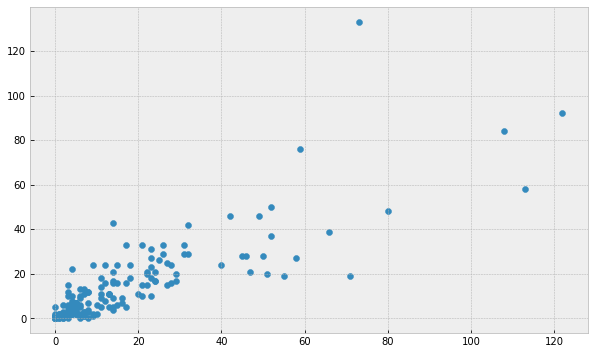

In [213]:
plt.figure(figsize=(10,6))
plt.scatter(X['nt'], X['y'])
plt.show()

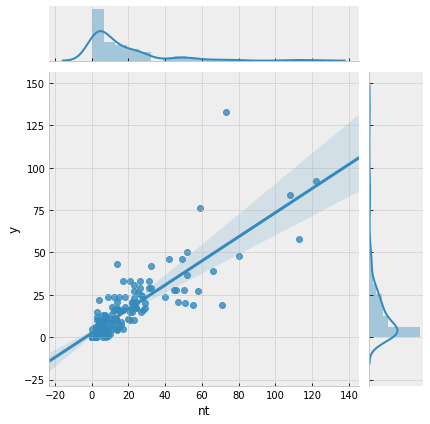

In [214]:
sns.jointplot('nt', 'y', data=X, kind='reg')

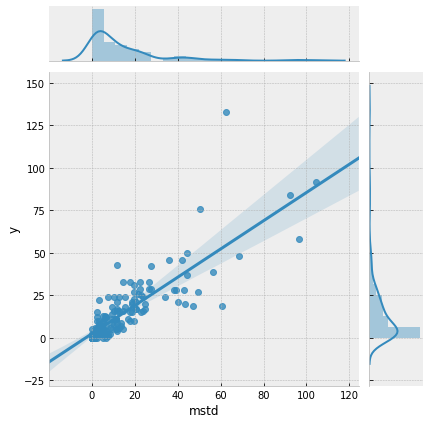

In [215]:
sns.jointplot('mstd', 'y', data=X, kind='reg')

looking at logistic likelihood linear likelohood  